In [4]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import glob
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

import xgboost as xgb

import os

In [5]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/root/train.csv'
# test_path  = '/root/test.csv'
dt = pd.read_csv(train_path)
# dt_test = pd.read_csv(test_path)

In [9]:
dt['구'] = dt['시군구'].map(lambda x : x.split()[1])
dt['동'] = dt['시군구'].map(lambda x : x.split()[2])

dt['계약년'] = dt['계약년월'].map(lambda x : x // 100)
dt['계약월'] = dt['계약년월'].map(lambda x : x % 100)

# df["date"] = pd.to_datetime(df['계약년'].astype(str) + '-' + df['계약월'].astype(str) + '-' + df['계약일'].astype(str))

In [11]:
dt.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', '구', '동', '계약년', '계약월',
       'yrs_diff_built_contract'],
      dtype='object')

In [10]:
dt['yrs_diff_built_contract'] = dt['계약년'] - dt['건축년도']

In [21]:
dt["계약년"].value_counts().sort_index()

2007     58767
2008     57012
2009     73491
2010     44457
2011     54513
2012     40851
2013     67865
2014     85130
2015    119891
2016     99253
2017    104893
2018     81413
2019     74696
2020     83711
2021     43117
2022     12214
2023     17548
Name: 계약년, dtype: int64

In [22]:
dt['건축년도'].value_counts().sort_index()

1961       54
1965       17
1966      105
1967       17
1968      251
1969      536
1970      688
1971     2396
1972      679
1973     1046
1974     3425
1975     2168
1976     2651
1977     2311
1978     8076
1979     7000
1980     9814
1981     5212
1982    11759
1983    14226
1984    10608
1985     8053
1986    23293
1987    25608
1988    55581
1989    23659
1990    15720
1991    15260
1992    32553
1993    30506
1994    25745
1995    27059
1996    32125
1997    42227
1998    44049
1999    59802
2000    56851
2001    42293
2002    41929
2003    65601
2004    68487
2005    48372
2006    34935
2007    29731
2008    37247
2009    24084
2010    21022
2011    20318
2012    16375
2013    13372
2014    17199
2015     8800
2016     8364
2017     4671
2018     4858
2019     4802
2020     2773
2021     1707
2022      673
2023       79
Name: 건축년도, dtype: int64

In [23]:
dt['yrs_diff_built_contract'].value_counts().sort_index()

-11    25
-10    21
-9     14
-8     10
-7     13
       ..
 57     6
 58     1
 59    11
 60     5
 61     1
Name: yrs_diff_built_contract, Length: 73, dtype: int64

Text(0.5, 1.0, '건축년도 별 평균거래가')

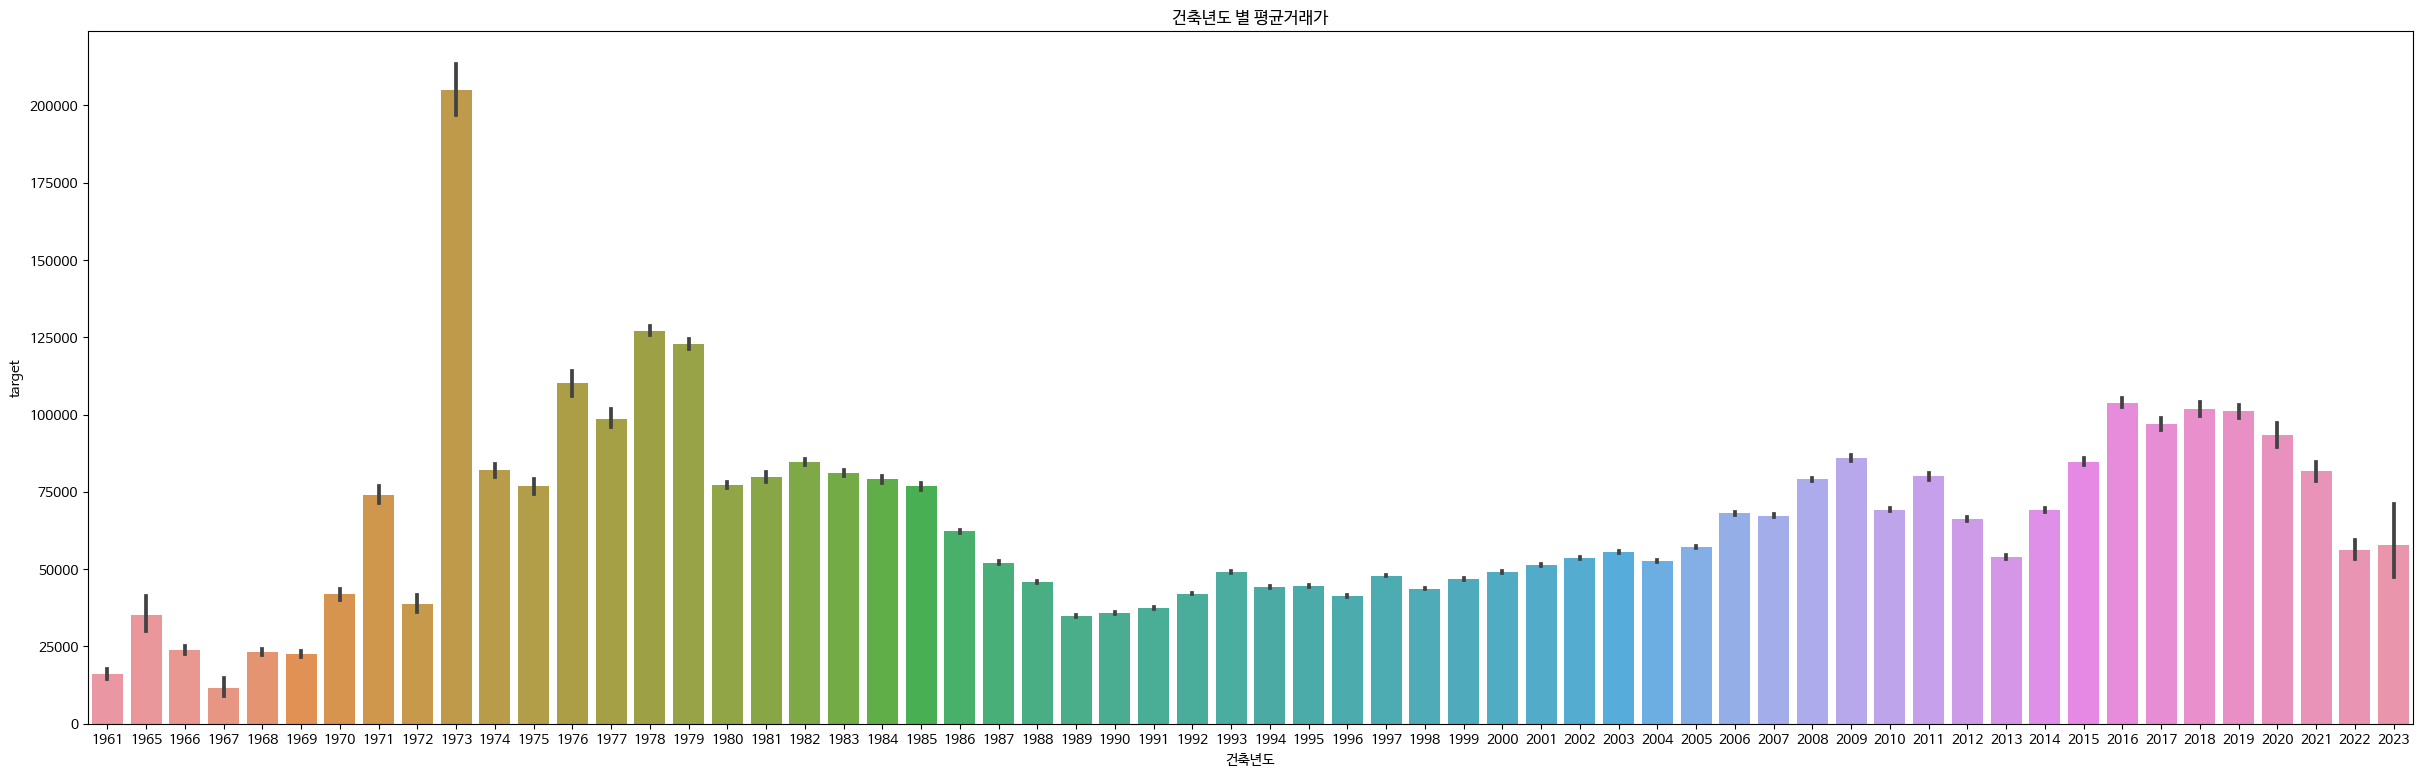

In [32]:
plt.figure(figsize=(30,9))
sns.barplot(data=dt, x='건축년도', y='target')
plt.title("건축년도 별 평균거래가")

Text(0.5, 1.0, '거래시점과 건축년도의 차이에 따른 평균거래가')

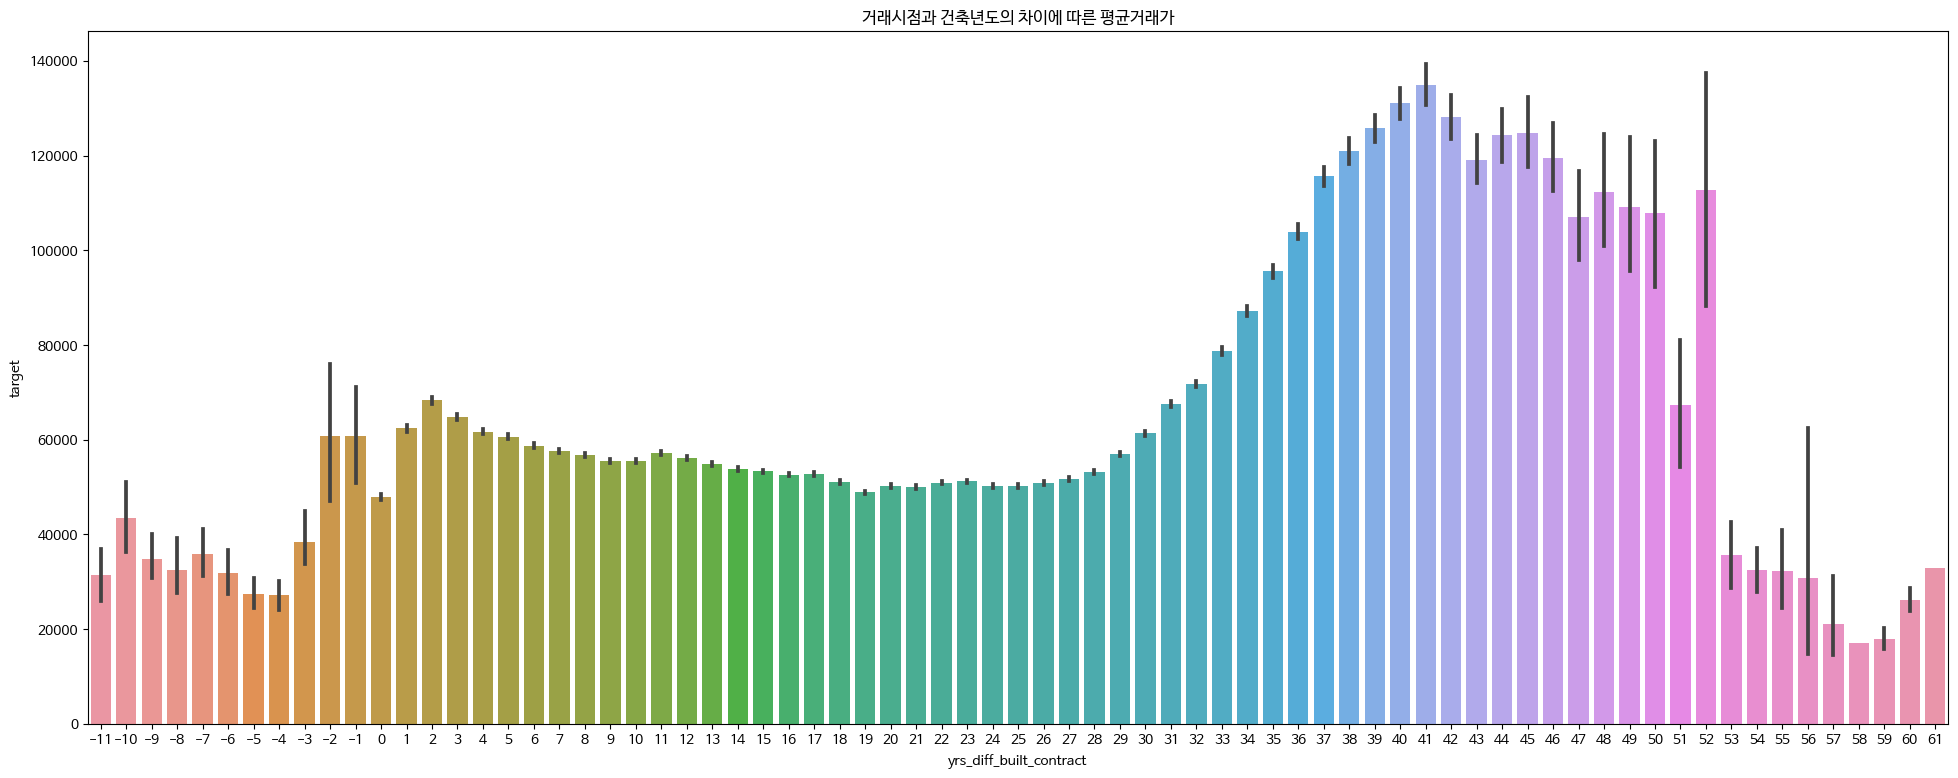

In [17]:
plt.figure(figsize=(24,9))
sns.barplot(data=dt, x='yrs_diff_built_contract', y='target')
plt.title("거래시점과 건축년도의 차이에 따른 평균거래가")

In [ ]:
dt[dt['yrs_diff_built_contract'] < 0].to_csv("years_diff_negative.csv", encoding="euc-kr")

In [ ]:
dt[dt['yrs_diff_built_contract'] < 0]['yrs_diff_built_contract'].value_counts().sort_index()

-11    25
-10    21
-9     14
-8     10
-7     13
-6     11
-5     13
-4     33
-3     48
-2     36
-1     90
Name: yrs_diff_built_contract, dtype: int64

In [37]:
pd.set_option('display.max_rows', None)

dt.groupby('yrs_diff_built_contract')['target'].max().sort_index()

yrs_diff_built_contract
-11      65000
-10      67500
-9       60000
-8       58500
-7       56000
-6       53000
-5       39750
-4       46300
-3      129500
-2      209000
-1      183000
 0      565000
 1     1200000
 2     1450000
 3      945000
 4      900000
 5      820000
 6      780000
 7      810000
 8      840000
 9      775000
 10     845000
 11    1100000
 12    1100000
 13    1053000
 14     810000
 15     700000
 16     580000
 17     900000
 18     680000
 19     622000
 20     870000
 21     555000
 22     600000
 23     526000
 24     500000
 25     640000
 26     420000
 27     415000
 28     325000
 29     380000
 30     380000
 31     430000
 32     332000
 33     395000
 34     450000
 35     470000
 36     540000
 37     720000
 38     604500
 39     595000
 40     630000
 41     670000
 42     800000
 43     628000
 44     620000
 45     640000
 46     800000
 47     780000
 48     650000
 49     730000
 50     680000
 51     450000
 52     585000
 53      84000
 

In [54]:
df_yrsdiff_max = pd.DataFrame(dt.groupby('yrs_diff_built_contract')['target'].max().sort_index())

In [55]:
df_yrsdiff_max

target
yrs_diff_built_contract         
-11                        65000
-10                        67500
-9                         60000
-8                         58500
-7                         56000
-6                         53000
-5                         39750
-4                         46300
-3                        129500
-2                        209000
-1                        183000
 0                        565000
 1                       1200000
 2                       1450000
 3                        945000
 4                        900000
 5                        820000
 6                        780000
 7                        810000
 8                        840000
 9                        775000
 10                       845000
 11                      1100000
 12                      1100000
 13                      1053000
 14                       810000
 15                       700000
 16                       580000
 17                       900000
 18                       680000
 19                       622000
 20                       870000
 21                       555000
 22                       600000
 23                       526000
 24                       500000
 25                       640000
 26                       420000
 27                       415000
 28                       325000
 29                       380000
 30                       380000
 31                       430000
 32                       332000
 33                       395000
 34                       450000
 35                       470000
 36                       540000
 37                       720000
 38                       604500
 39                       595000
 40                       630000
 41                       670000
 42                       800000
 43                       628000
 44                       620000
 45                       640000
 46                       800000
 47                       780000
 48                       650000
 49                       730000
 50                       680000
 51                       450000
 52                       585000
 53                        84000
 54                        56000
 55                        60000
 56                        62500
 57                        45000
 58                        17000
 59                        23500
 60                        30000
 61                        33000

In [59]:
dt.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', '구', '동', '계약년', '계약월',
       'yrs_diff_built_contract'],
      dtype='object')

In [68]:
# Define a custom function to round the mean to 2 decimals
def mean_rounded(x):
    return np.round(np.mean(x), 2)

# Create the pivot table with custom aggregation functions
pivot_table = pd.pivot_table(data=dt, values=["target"], index=["yrs_diff_built_contract"], aggfunc={"target": [mean_rounded, "max"]}).sort_index()
# Display the pivot table
display(pivot_table)

target             
                             max mean_rounded
yrs_diff_built_contract                      
-11                        65000     31336.40
-10                        67500     43452.38
-9                         60000     34885.71
-8                         58500     32520.00
-7                         56000     35811.54
-6                         53000     31740.91
-5                         39750     27507.69
-4                         46300     27090.24
-3                        129500     38455.21
-2                        209000     60802.25
-1                        183000     60707.43
 0                        565000     47940.43
 1                       1200000     62424.85
 2                       1450000     68322.41
 3                        945000     64837.19
 4                        900000     61703.60
 5                        820000     60607.06
 6                        780000     58716.13
 7                        810000     57574.57
 8                        840000     56781.50
 9                        775000     55527.62
 10                       845000     55526.81
 11                      1100000     57238.52
 12                      1100000     56123.60
 13                      1053000     54957.28
 14                       810000     53776.20
 15                       700000     53277.71
 16                       580000     52610.14
 17                       900000     52719.81
 18                       680000     51119.85
 19                       622000     48853.67
 20                       870000     50187.48
 21                       555000     49993.81
 22                       600000     50920.99
 23                       526000     51168.49
 24                       500000     50311.20
 25                       640000     50239.26
 26                       420000     50779.80
 27                       415000     51750.47
 28                       325000     53141.20
 29                       380000     56948.62
 30                       380000     61323.59
 31                       430000     67610.69
 32                       332000     71765.97
 33                       395000     78755.19
 34                       450000     87218.84
 35                       470000     95526.46
 36                       540000    103915.32
 37                       720000    115644.58
 38                       604500    120945.40
 39                       595000    125744.28
 40                       630000    131099.44
 41                       670000    134976.39
 42                       800000    128068.19
 43                       628000    119127.24
 44                       620000    124249.35
 45                       640000    124697.27
 46                       800000    119412.85
 47                       780000    107020.10
 48                       650000    112338.38
 49                       730000    109178.73
 50                       680000    107779.12
 51                       450000     67275.16
 52                       585000    112750.00
 53                        84000     35594.00
 54                        56000     32445.83
 55                        60000     32233.33
 56                        62500     30733.33
 57                        45000     20991.67
 58                        17000     17000.00
 59                        23500     17986.36
 60                        30000     26200.00
 61                        33000     33000.00

In [63]:
pd.pivot_table(data=dt, values="target", index ='yrs_diff_built_contract', aggfunc=["mean", "min", "max", "std"]).sort_index().columns


MultiIndex([('mean', 'target'),
            ( 'min', 'target'),
            ( 'max', 'target'),
            ( 'std', 'target')],
           )

<Axes: xlabel='yrs_diff_built_contract', ylabel='target'>

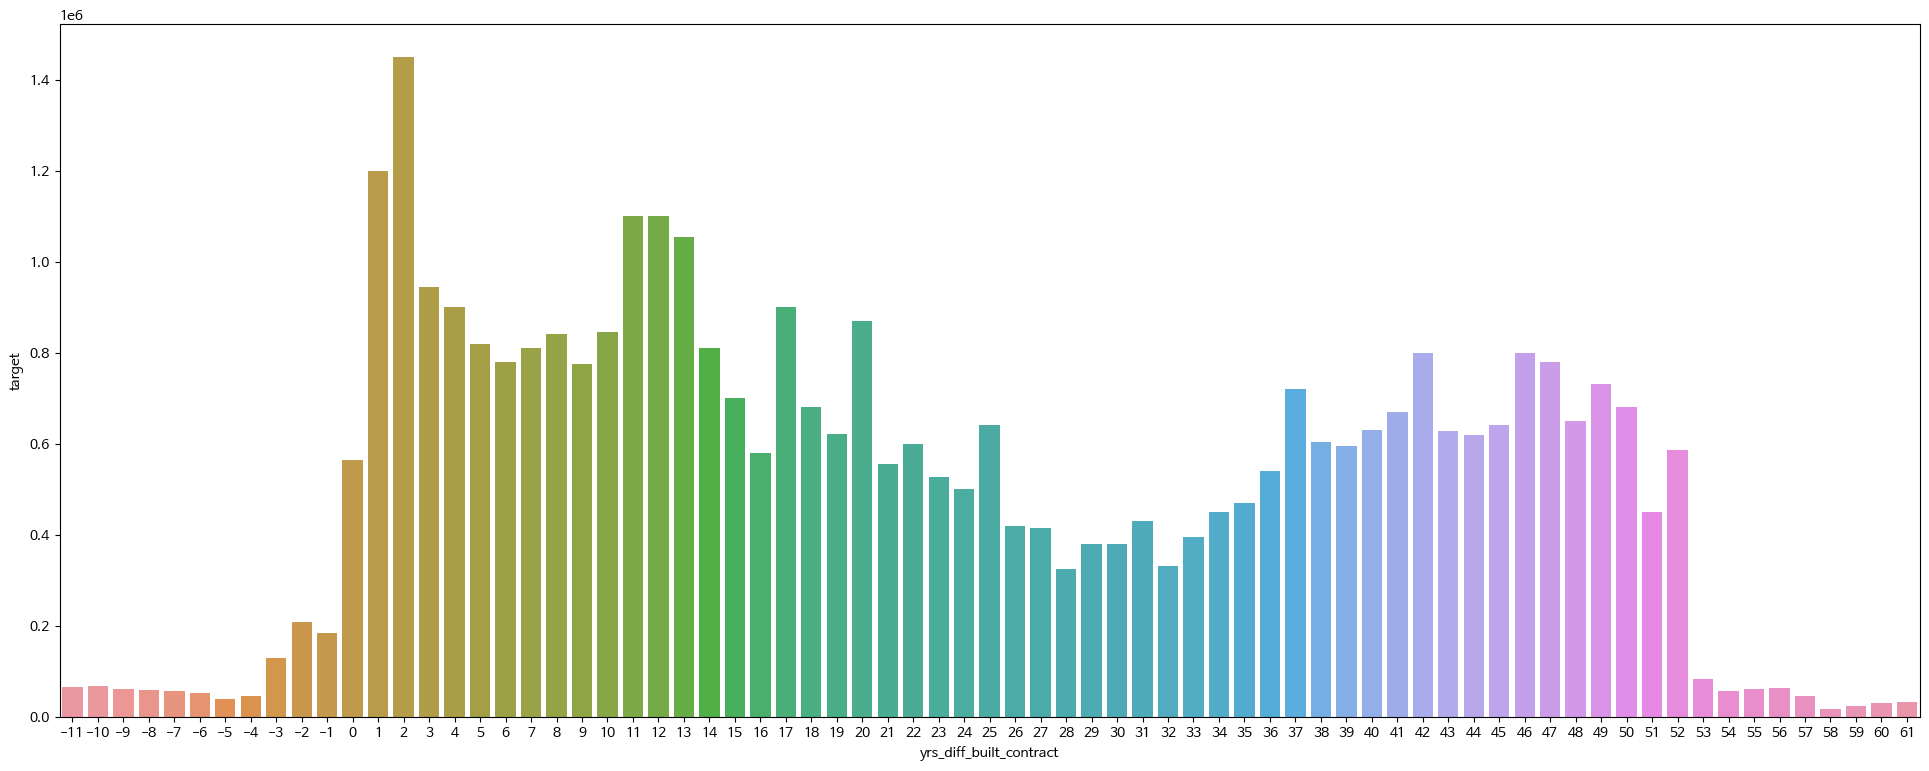

In [46]:
plt.figure(figsize=(24,9))
sns.barplot(data=df_yrsdiff_max, x=df_yrsdiff_max.index, y="target")

In [73]:
dt[dt['yrs_diff_built_contract'] == 1]["target"].min()

2500

In [74]:
dt[dt['yrs_diff_built_contract'] == 1]["target"].mean()

62424.853355719526

In [75]:
dt[dt['yrs_diff_built_contract'] == 1]["target"].max()

1200000

In [31]:
dt[dt['yrs_diff_built_contract'] == -11]

시군구    번지    본번   부번 아파트명  전용면적(㎡)    계약년월  계약일   층  건축년도  \
1037882  서울특별시 노원구 중계동  34-5  34.0  5.0   현대    84.98  200710    8  14  2018   
1037883  서울특별시 노원구 중계동  34-5  34.0  5.0   현대    59.84  200711   10  12  2018   
1037884  서울특별시 노원구 중계동  34-5  34.0  5.0   현대    59.84  200712    7   9  2018   
1037885  서울특별시 노원구 중계동  34-5  34.0  5.0   현대    84.98  200712   19  14  2018   
1037886  서울특별시 노원구 중계동  34-5  34.0  5.0   현대    59.84  200712   29  14  2018   
1095376  서울특별시 노원구 중계동  34-5  34.0  5.0   현대   122.69  200701    6  19  2018   
1095377  서울특별시 노원구 중계동  34-5  34.0  5.0   현대    59.84  200701   31  18  2018   
1095378  서울특별시 노원구 중계동  34-5  34.0  5.0   현대    84.98  200702   10   8  2018   
1095379  서울특별시 노원구 중계동  34-5  34.0  5.0   현대    84.98  200703    6   3  2018   
1095380  서울특별시 노원구 중계동  34-5  34.0  5.0   현대    84.98  200704    4  14  2018   
1095381  서울특별시 노원구 중계동  34-5  34.0  5.0   현대    84.98  200704   21  16  2018   
1095382  서울특별시 노원구 중계동  34-5  34.0  5.0   현대    59.84  200704   28  13  2018   
1095383  서울특별시 노원구 중계동  34-5  34.0  5.0   현대    59.84  200704   30  19  2018   
1095384  서울특별시 노원구 중계동  34-5  34.0  5.0   현대    59.84  200706   16  10  2018   
1095385  서울특별시 노원구 중계동  34-5  34.0  5.0   현대    59.84  200706   25  11  2018   
1095386  서울특별시 노원구 중계동  34-5  34.0  5.0   현대    84.98  200707    2   6  2018   
1095387  서울특별시 노원구 중계동  34-5  34.0  5.0   현대    84.98  200707   16  16  2018   
1095388  서울특별시 노원구 중계동  34-5  34.0  5.0   현대   122.69  200707   20  13  2018   
1095389  서울특별시 노원구 중계동  34-5  34.0  5.0   현대    84.98  200708   15  17  2018   
1095390  서울특별시 노원구 중계동  34-5  34.0  5.0   현대    59.84  200708   31  16  2018   
1095391  서울특별시 노원구 중계동  34-5  34.0  5.0   현대    59.84  200709    4  11  2018   
1095392  서울특별시 노원구 중계동  34-5  34.0  5.0   현대    59.84  200709    4   1  2018   
1095393  서울특별시 노원구 중계동  34-5  34.0  5.0   현대   122.69  200709    7   7  2018   
1095394  서울특별시 노원구 중계동  34-5  34.0  5.0   현대    59.84  200709   10  13  2018   
1095395  서울특별시 노원구 중계동  34-5  34.0  5.0   현대    59.84  200709   18   1  2018   

         ... 관리비 업로드  좌표X 좌표Y 단지신청일 target    구    동   계약년  계약월  \
1037882  ...     NaN  NaN NaN   NaN  39000  노원구  중계동  2007   10   
1037883  ...     NaN  NaN NaN   NaN  22700  노원구  중계동  2007   11   
1037884  ...     NaN  NaN NaN   NaN  20000  노원구  중계동  2007   12   
1037885  ...     NaN  NaN NaN   NaN  41000  노원구  중계동  2007   12   
1037886  ...     NaN  NaN NaN   NaN  23560  노원구  중계동  2007   12   
1095376  ...     NaN  NaN NaN   NaN  57000  노원구  중계동  2007    1   
1095377  ...     NaN  NaN NaN   NaN  19800  노원구  중계동  2007    1   
1095378  ...     NaN  NaN NaN   NaN  39000  노원구  중계동  2007    2   
1095379  ...     NaN  NaN NaN   NaN  36550  노원구  중계동  2007    3   
1095380  ...     NaN  NaN NaN   NaN  37600  노원구  중계동  2007    4   
1095381  ...     NaN  NaN NaN   NaN  34000  노원구  중계동  2007    4   
1095382  ...     NaN  NaN NaN   NaN  19200  노원구  중계동  2007    4   
1095383  ...     NaN  NaN NaN   NaN  18000  노원구  중계동  2007    4   
1095384  ...     NaN  NaN NaN   NaN  20000  노원구  중계동  2007    6   
1095385  ...     NaN  NaN NaN   NaN  18800  노원구  중계동  2007    6   
1095386  ...     NaN  NaN NaN   NaN  38500  노원구  중계동  2007    7   
1095387  ...     NaN  NaN NaN   NaN  36500  노원구  중계동  2007    7   
1095388  ...     NaN  NaN NaN   NaN  65000  노원구  중계동  2007    7   
1095389  ...     NaN  NaN NaN   NaN  40700  노원구  중계동  2007    8   
1095390  ...     NaN  NaN NaN   NaN  21000  노원구  중계동  2007    8   
1095391  ...     NaN  NaN NaN   NaN  22000  노원구  중계동  2007    9   
1095392  ...     NaN  NaN NaN   NaN  16500  노원구  중계동  2007    9   
1095393  ...     NaN  NaN NaN   NaN  59600  노원구  중계동  2007    9   
1095394  ...     NaN  NaN NaN   NaN  20900  노원구  중계동  2007    9   
1095395  ...     NaN  NaN NaN   NaN  16500  노원구  중계동  2007    9   

        yrs_diff_built_contract  
1037882                     -11  
1037883                     -11  
1037884                     -11  
1037885                     -11  
1037886                  

In [70]:
dt.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', '구', '동', '계약년', '계약월',
       'yrs_diff_built_contract'],
      dtype='object')

In [109]:
temp_df = pd.DataFrame()

In [110]:
temp_df['yrs_diff_built_contract'] = dt['yrs_diff_built_contract'].unique().sort_values(by='yrs_diff_built_contract')

In [111]:
temp_df = temp_df.sort_values(by='yrs_diff_built_contract')

In [112]:
temp_df['yrs_diff_built_contract'].min()

-11

In [113]:
temp_df['yrs_diff_built_contract'].max()

61

In [127]:
# Create empty lists to store min, mean, and max values
min_list = []
mean_list = []
max_list = []

# Iterate over unique values of 'yrs_diff_built_contract'
for value in temp_df['yrs_diff_built_contract']:
    # Filter the DataFrame for the current value
    filtered_df = dt[dt['yrs_diff_built_contract'] == value]
    # Calculate min, mean, and max for the target column
    min_val = filtered_df["target"].min()
    mean_val = filtered_df["target"].mean().round(2)
    max_val = filtered_df["target"].max()
    # Append the values to the lists
    min_list.append(min_val)
    mean_list.append(mean_val)
    max_list.append(max_val)

# Add lists as new columns to temp_df
temp_df['min'] = min_list
temp_df['mean'] = mean_list
temp_df['max'] = max_list

In [128]:
temp_df

yrs_diff_built_contract    min       mean      max
72                      -11  16500   31336.40    65000
57                      -10  15800   43452.38    67500
58                       -9  26800   34885.71    60000
71                       -8  26000   32520.00    58500
55                       -7  26000   35811.54    56000
56                       -6  21150   31740.91    53000
70                       -5  20000   27507.69    39750
69                       -4  18106   27090.24    46300
68                       -3  18600   38455.21   129500
65                       -2  24000   60802.25   209000
42                       -1  11998   60707.43   183000
41                        0    630   47940.43   565000
22                        1   2500   62424.85  1200000
23                        2   2000   68322.41  1450000
8                         3    500   64837.19   945000
9                         4   4600   61703.60   900000
35                        5   3300   60607.06   820000
36                        6   3000   58716.13   780000
38                        7   3000   57574.57   810000
34                        8   1262   56781.50   840000
15                        9   1000   55527.62   775000
16                       10   1100   55526.81   845000
17                       11    350   57238.52  1100000
18                       12   2000   56123.60  1100000
4                        13   2500   54957.28  1053000
5                        14   3200   53776.20   810000
28                       15   6200   53277.71   700000
25                       16   1500   52610.14   580000
10                       17   4000   52719.81   900000
11                       18   1000   51119.85   680000
12                       19   6000   48853.67   622000
37                       20   1100   50187.48   870000
32                       21   4500   49993.81   555000
33                       22   7000   50920.99   600000
30                       23   6000   51168.49   526000
31                       24   5400   50311.20   500000
26                       25   4000   50239.26   640000
27                       26   4000   50779.80   420000
29                       27   4000   51750.47   415000
13                       28   3500   53141.20   325000
14                       29   6000   56948.62   380000
0                        30   4500   61323.59   380000
1                        31   5000   67610.69   430000
21                       32   3900   71765.97   332000
2                        33   2263   78755.19   395000
3                        34   3362   87218.84   450000
6                        35   4500   95526.46   470000
7                        36   1031  103915.32   540000
43                       37   3400  115644.58   720000
24                       38   2000  120945.40   604500
19                       39   5500  125744.28   595000
20                       40   4000  131099.44   630000
39                       41   4300  134976.39   670000
40                       42   6000  128068.19   800000
44                       43   7100  119127.24   628000
45                       44   5000  124249.35   620000
50                       45   2000  124697.27   640000
47                       46   2700  119412.85   800000
46                       47   7000  107020.10   780000
51                       48   8450  112338.38   650000
52                       49   8300  109178.73   730000
49                       50   7500  107779.12   680000
54                       51   9000   67275.16   450000
53                       52  19800  112750.00   585000
60                       53  13000   35594.00    84000
59                       54   7900   32445.83    56000
61                       55  17000   32233.33    60000
66                       56  14800   30733.33    62500
48                       57  11500   20991.67    45000
67                       58  17000   17000.00    17000
63                       59  12000   17986.36    23500
64                       60  22000   26200.0

In [130]:
'Blues_r'[0]

'B'

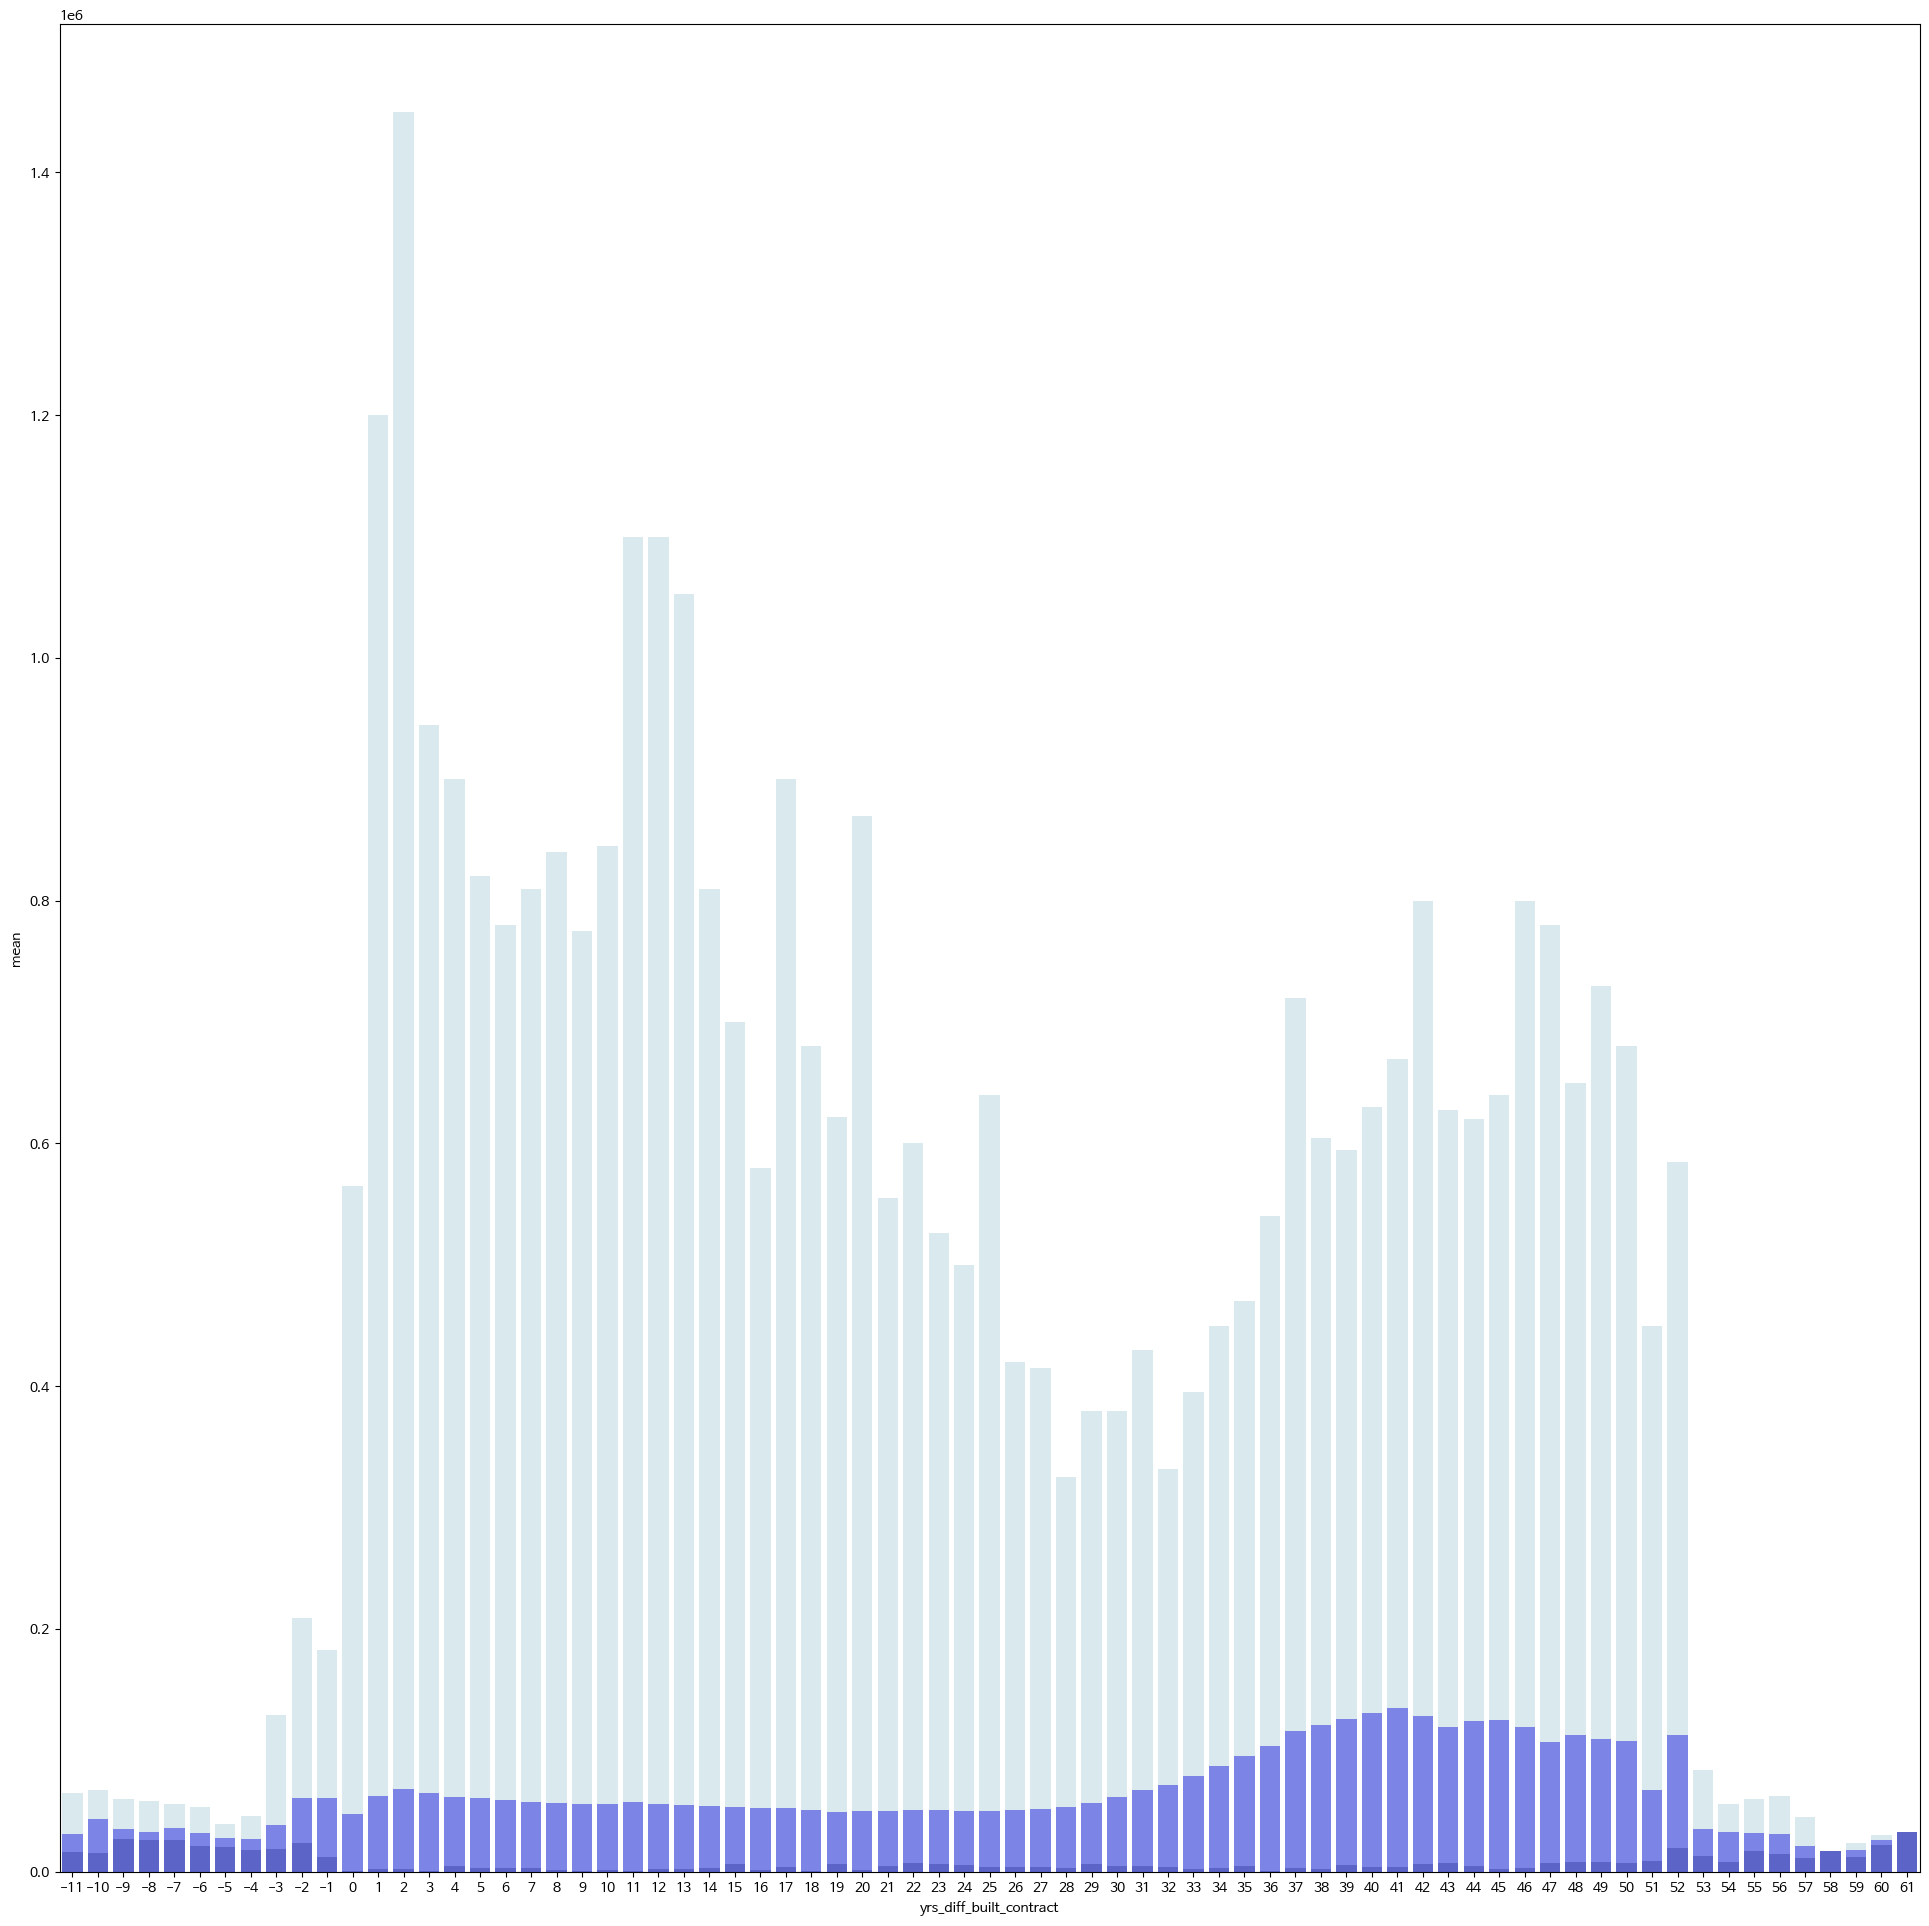

In [137]:
plt.figure(figsize=(24, 24))

# Define colors for min, mean, and max
colors = ["black", "blue", "lightblue"]

# Plot the barplots
sns.barplot(data=temp_df, x='yrs_diff_built_contract', y='min', alpha=0.5, color=colors[0])
sns.barplot(data=temp_df, x='yrs_diff_built_contract', y='max', alpha=0.5, color=colors[2])
sns.barplot(data=temp_df, x='yrs_diff_built_contract', y='mean', alpha=0.5, color=colors[1])

plt.show()


In [145]:
# def dist_per_gu(gu):
#     df_gu = dt[dt['구'] == gu]
#     temp_df = pd.DataFrame()
#     temp_df['yrs_diff'] = dt['yrs_diff_built_contract'].unique()
#     temp_df['yrs_diff'] = temp_df['yrs_diff'].sort_values()
    
#     min_list = []
#     mean_list = []
#     max_list = []
#     # Iterate over unique values of 'yrs_diff_built_contract'
#     for value in temp_df['yrs_diff_built_contract']:
#         # Filter the DataFrame for the current value
#         filtered_df = dt[dt['yrs_diff_built_contract'] == value]
#         # Calculate min, mean, and max for the target column
#         min_val = filtered_df["target"].min()
#         mean_val = filtered_df["target"].mean().round(2)
#         max_val = filtered_df["target"].max()
#         # Append the values to the lists
#         min_list.append(min_val)
#         mean_list.append(mean_val)
#         max_list.append(max_val)

#     # Add lists as new columns to temp_df
#     temp_df['min'] = min_list
#     temp_df['mean'] = mean_list
#     temp_df['max'] = max_list
    
#     return temp_df

In [146]:
# for gu in dt['구'].unique():
#     temp_df_gu = dist_per_gu(gu)
#     plt.figure(figsize=(24, 24))

#     # Define colors for min, mean, and max
#     colors = ["black", "blue", "lightblue"]

#     # Plot the barplots
#     sns.barplot(data=temp_df_gu, x='yrs_diff_built_contract', y='min', alpha=0.5, color=colors[0])
#     sns.barplot(data=temp_df_gu, x='yrs_diff_built_contract', y='max', alpha=0.5, color=colors[2])
#     sns.barplot(data=temp_df_gu, x='yrs_diff_built_contract', y='mean', alpha=0.5, color=colors[1])

#     plt.show()

    

KeyError: 'yrs_diff_built_contract'

In [148]:
def dist_per_gu(gu):
    df_gu = dt[dt['구'] == gu]
    temp_df = pd.DataFrame()
    temp_df['yrs_diff'] = df_gu['yrs_diff_built_contract'].unique()
    temp_df['yrs_diff'] = temp_df['yrs_diff'].sort_values()

    min_list = []
    mean_list = []
    max_list = []
    # Iterate over unique values of 'yrs_diff_built_contract'
    for value in temp_df['yrs_diff']:
        # Filter the DataFrame for the current value
        filtered_df = df_gu[df_gu['yrs_diff_built_contract'] == value]
        # Calculate min, mean, and max for the target column
        min_val = filtered_df["target"].min()
        mean_val = filtered_df["target"].mean().round(2)
        max_val = filtered_df["target"].max()
        # Append the values to the lists
        min_list.append(min_val)
        mean_list.append(mean_val)
        max_list.append(max_val)

    # Add lists as new columns to temp_df
    temp_df['min'] = min_list
    temp_df['mean'] = mean_list
    temp_df['max'] = max_list

    return temp_df

In [149]:
dt['구'].unique()

array(['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구',
       '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구',
       '양천구', '영등포구', '용산구', '은평구', '종로구', '중구', '중랑구'], dtype=object)

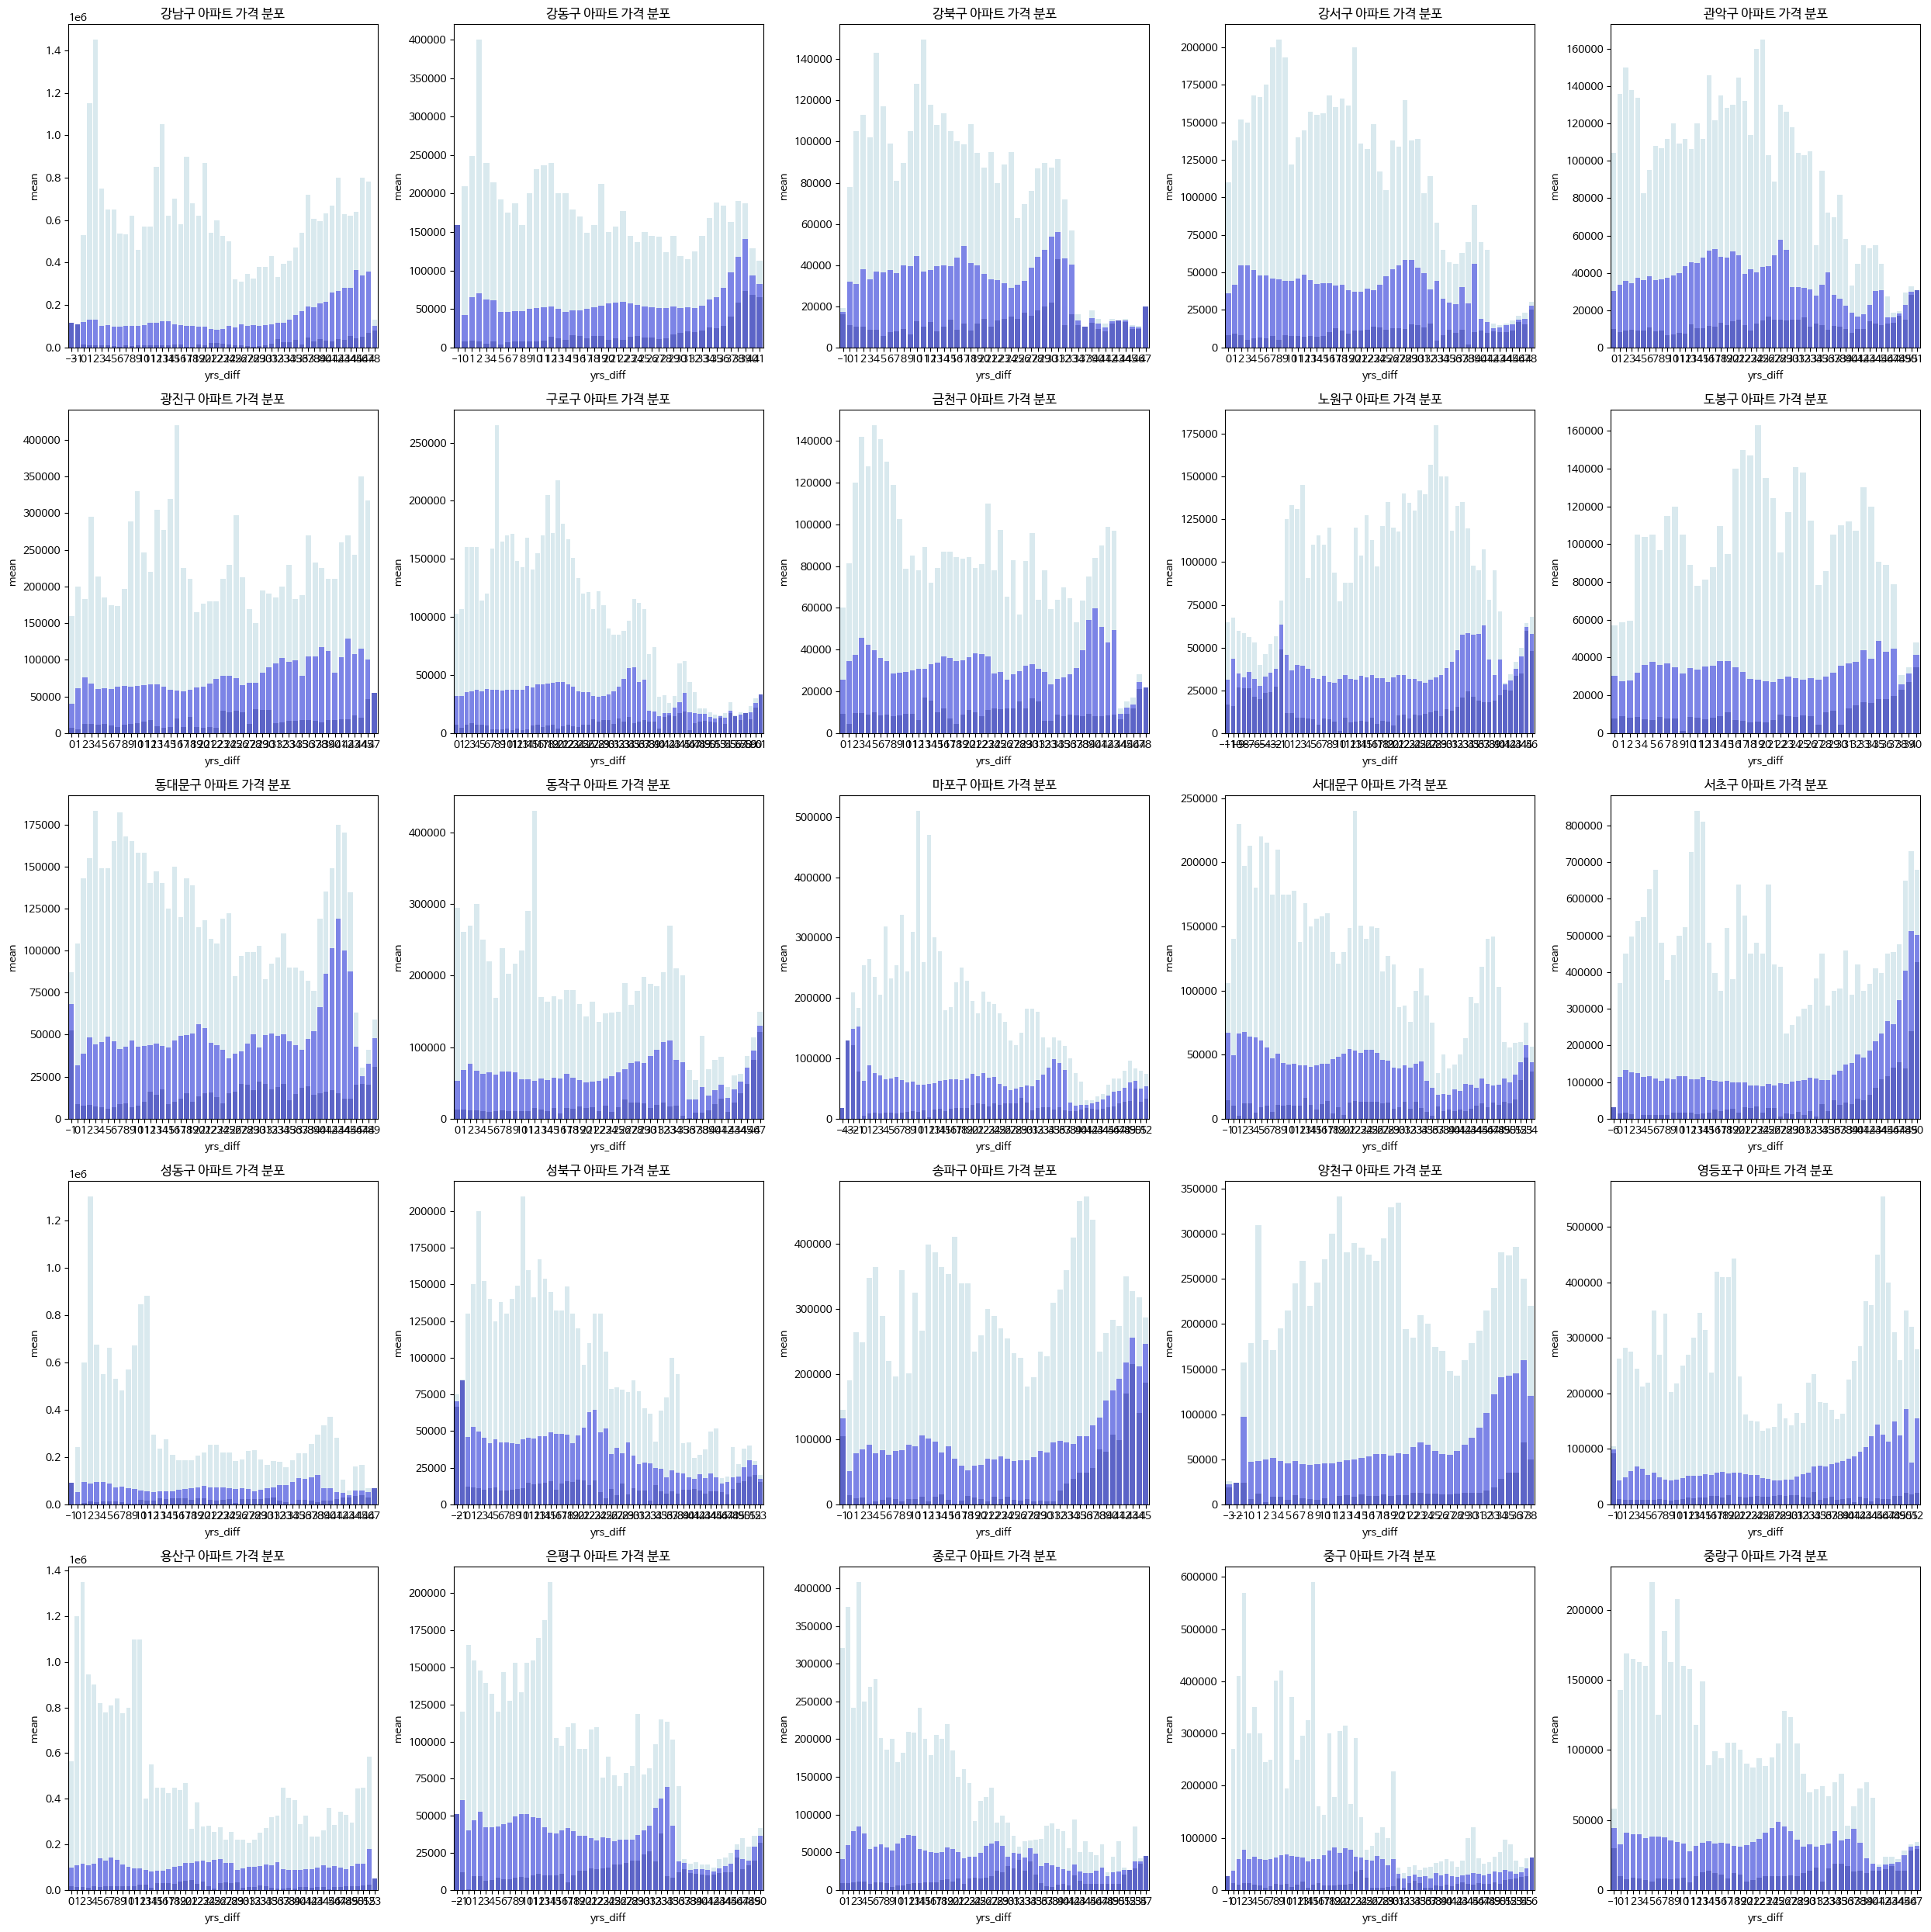

In [151]:
rows = 5
cols = 5

fig, axs = plt.subplots(nrows = rows, ncols = cols, figsize = (25,25))

for i, district in enumerate(dt['구'].unique().tolist()):
    row = i // cols
    col = i % cols
    
    temp_df_gu = dist_per_gu(district)

    # Plot the barplots
    sns.barplot(data=temp_df_gu, x='yrs_diff', y='min', alpha=0.5, color='black', ax=axs[row, col])
    sns.barplot(data=temp_df_gu, x='yrs_diff', y='max', alpha=0.5, color='lightblue', ax=axs[row, col])
    sns.barplot(data=temp_df_gu, x='yrs_diff', y='mean', alpha=0.5, color='blue', ax=axs[row, col])
    
    axs[row, col].set_title(f"{district} 아파트 가격 분포")
    
plt.tight_layout()
plt.show()


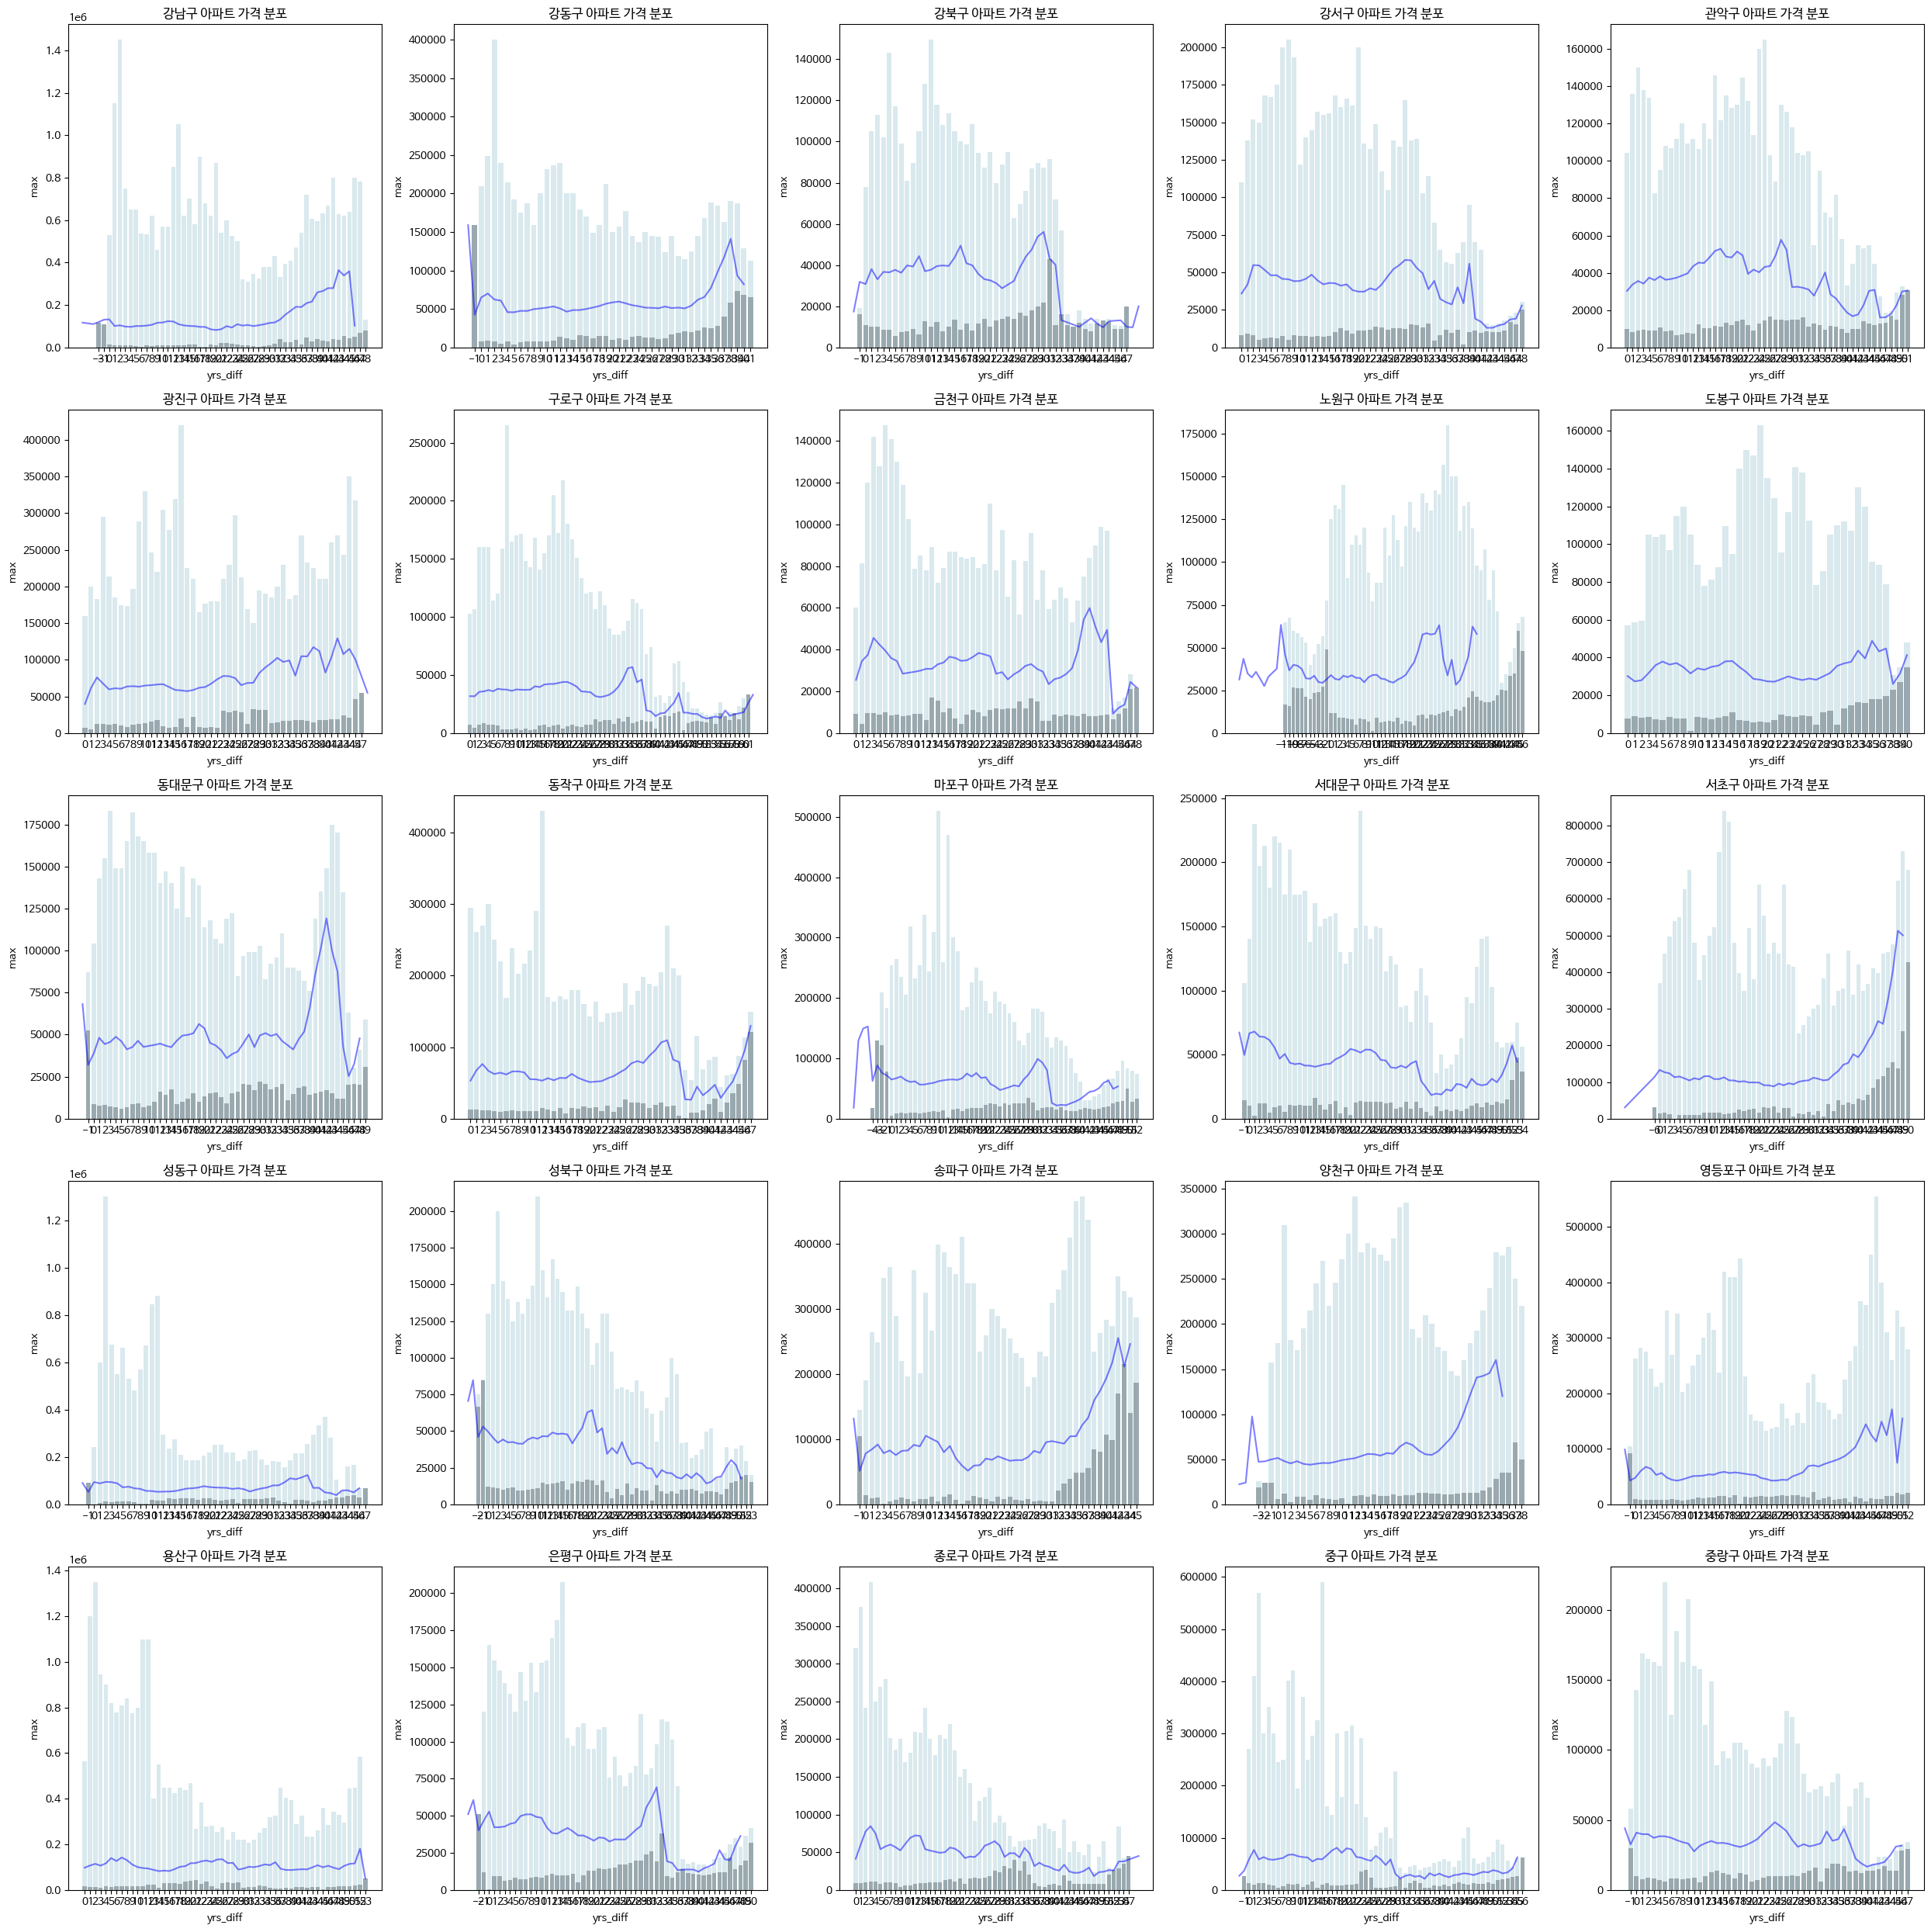

In [152]:
rows = 5
cols = 5

fig, axs = plt.subplots(nrows = rows, ncols = cols, figsize = (25,25))

for i, district in enumerate(dt['구'].unique().tolist()):
    row = i // cols
    col = i % cols
    
    temp_df_gu = dist_per_gu(district)

    # Plot the barplots
    colors = ["black", "blue", "lightblue"]

    sns.barplot(data=temp_df_gu, x='yrs_diff', y='min', alpha=0.5, color=colors[0], ax=axs[row, col])
    sns.barplot(data=temp_df_gu, x='yrs_diff', y='max', alpha=0.5, color=colors[2], ax=axs[row, col])
    sns.lineplot(data=temp_df_gu, x='yrs_diff', y='mean', alpha=0.5, color=colors[1], ax=axs[row, col])
    
    axs[row, col].set_title(f"{district} 아파트 가격 분포")
    
plt.tight_layout()
plt.show()


In [153]:
pd.reset_option('display.max_rows')

In [155]:
len(dt['동'].unique())

337

In [158]:
def dist_per_dong(dong):
    df_dong = dt[dt['동'] == dong]
    temp_df = pd.DataFrame()
    temp_df['yrs_diff'] = df_dong['yrs_diff_built_contract'].unique()
    temp_df['yrs_diff'] = temp_df['yrs_diff'].sort_values()

    min_list = []
    mean_list = []
    max_list = []
    # Iterate over unique values of 'yrs_diff_built_contract'
    for value in temp_df['yrs_diff']:
        # Filter the DataFrame for the current value
        filtered_df = df_dong[df_dong['yrs_diff_built_contract'] == value]
        # Calculate min, mean, and max for the target column
        min_val = filtered_df["target"].min()
        mean_val = filtered_df["target"].mean().round(2)
        max_val = filtered_df["target"].max()
        # Append the values to the lists
        min_list.append(min_val)
        mean_list.append(mean_val)
        max_list.append(max_val)

    # Add lists as new columns to temp_df
    temp_df['min'] = min_list
    temp_df['mean'] = mean_list
    temp_df['max'] = max_list

    return temp_df

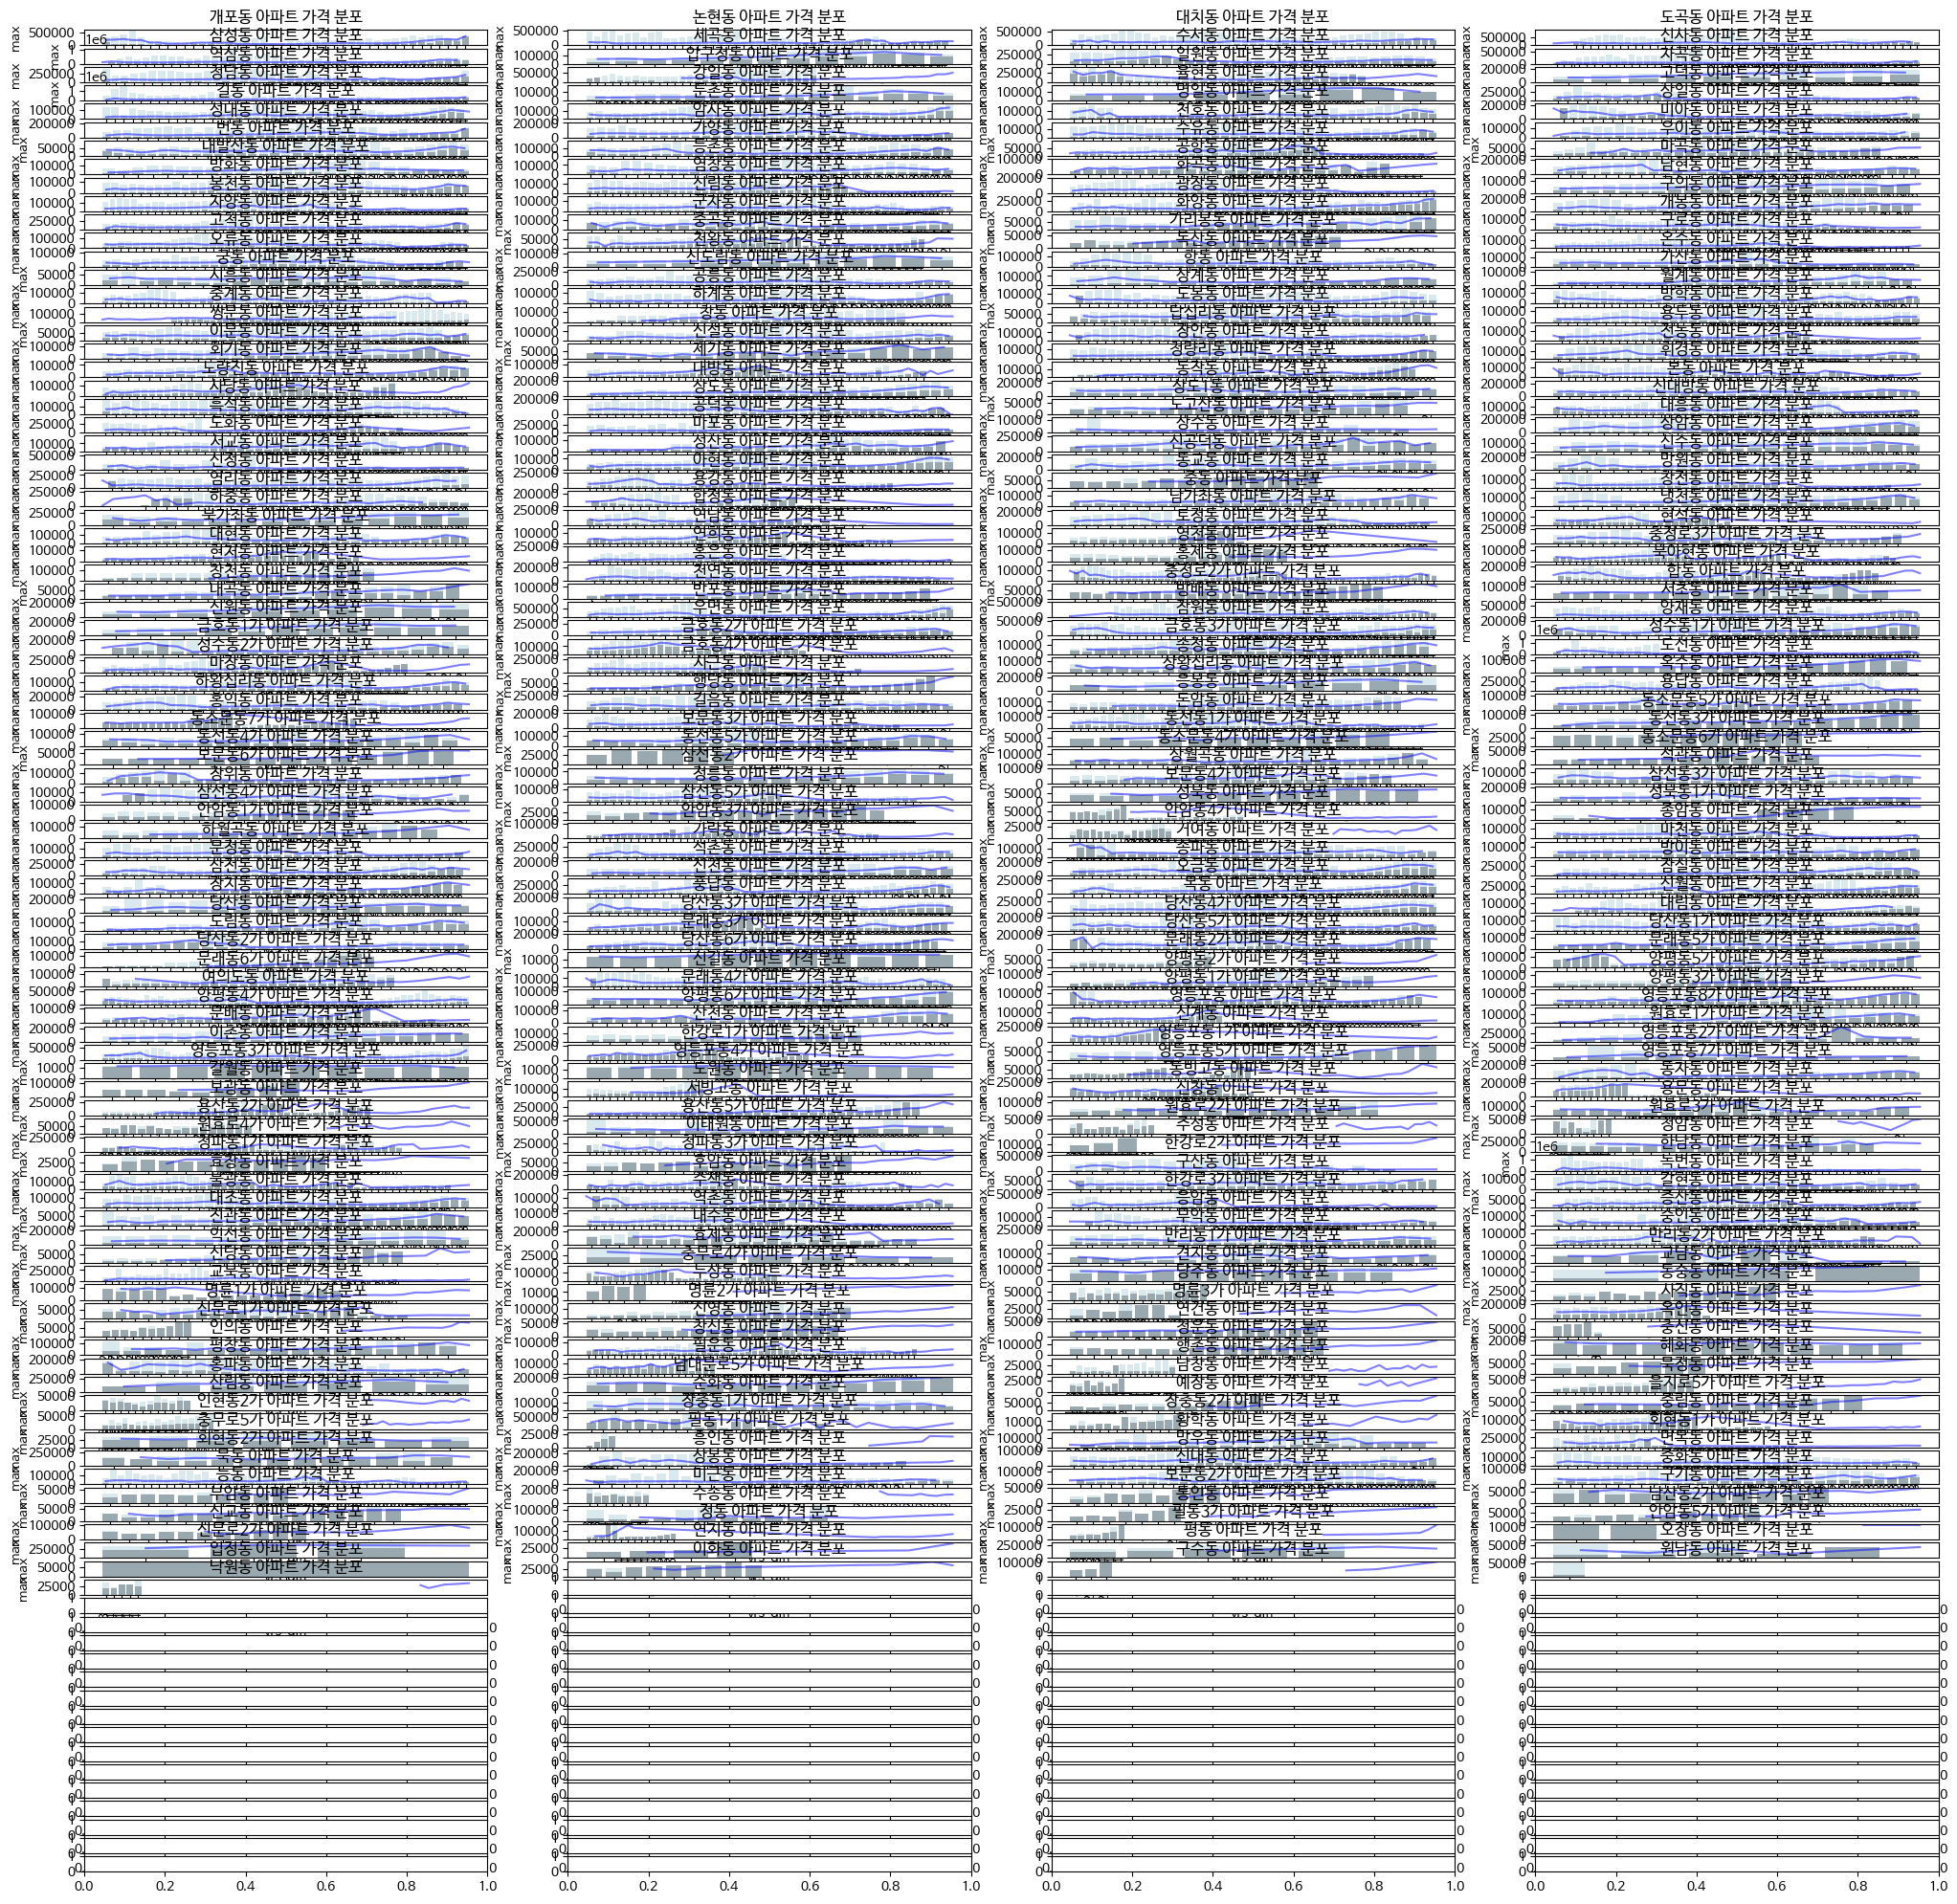

In [159]:
rows = 100
cols = 4

fig, axs = plt.subplots(nrows = rows, ncols = cols, figsize = (25, 25))

for i, district in enumerate(dt['동'].unique().tolist()):
    row = i // cols
    col = i % cols
    
    temp_df_dong = dist_per_dong(district)

    # Plot the barplots
    colors = ["black", "blue", "lightblue"]

    sns.barplot(data=temp_df_dong, x='yrs_diff', y='min', alpha=0.5, color=colors[0], ax=axs[row, col])
    sns.barplot(data=temp_df_dong, x='yrs_diff', y='max', alpha=0.5, color=colors[2], ax=axs[row, col])
    sns.lineplot(data=temp_df_dong, x='yrs_diff', y='mean', alpha=0.5, color=colors[1], ax=axs[row, col])
    
    axs[row, col].set_title(f"{district} 아파트 가격 분포")
    axs[row, col].tick_params(axis='x', rotation=90)
    
plt.tight_layout()
plt.show()


In [160]:
dt['구'].unique()

array(['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구',
       '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구',
       '양천구', '영등포구', '용산구', '은평구', '종로구', '중구', '중랑구'], dtype=object)

In [177]:
dt_gangnam = dt[dt['구'] == '강남구']
dt_yongsan = dt[dt['구'] == '용산구']
dt_seongbuk = dt[dt['구'] == '성북구']
dt_seongdong = dt[dt['구'] == '성동구']
dt_yeongdeung = dt[dt['구'] == '영등포구']
dt_songpa = dt[dt['구'] == '송파구']

In [163]:
dt_gangnam['동'].unique()

array(['개포동', '논현동', '대치동', '도곡동', '삼성동', '세곡동', '수서동', '신사동', '역삼동',
       '압구정동', '일원동', '자곡동', '청담동', '율현동'], dtype=object)

In [173]:
dt_yongsan['동'].unique()

array(['문배동', '산천동', '신계동', '원효로1가', '이촌동', '한강로1가', '갈월동', '도원동', '동빙고동',
       '동자동', '보광동', '서빙고동', '신창동', '용문동', '용산동2가', '용산동5가', '원효로2가',
       '원효로3가', '원효로4가', '이태원동', '주성동', '청암동', '청파동1가', '청파동3가', '한강로2가',
       '한남동', '효창동', '후암동', '한강로3가'], dtype=object)

In [164]:
len(dt_gangnam['동'].unique())

14

In [174]:
len(dt_yongsan['동'].unique())

29

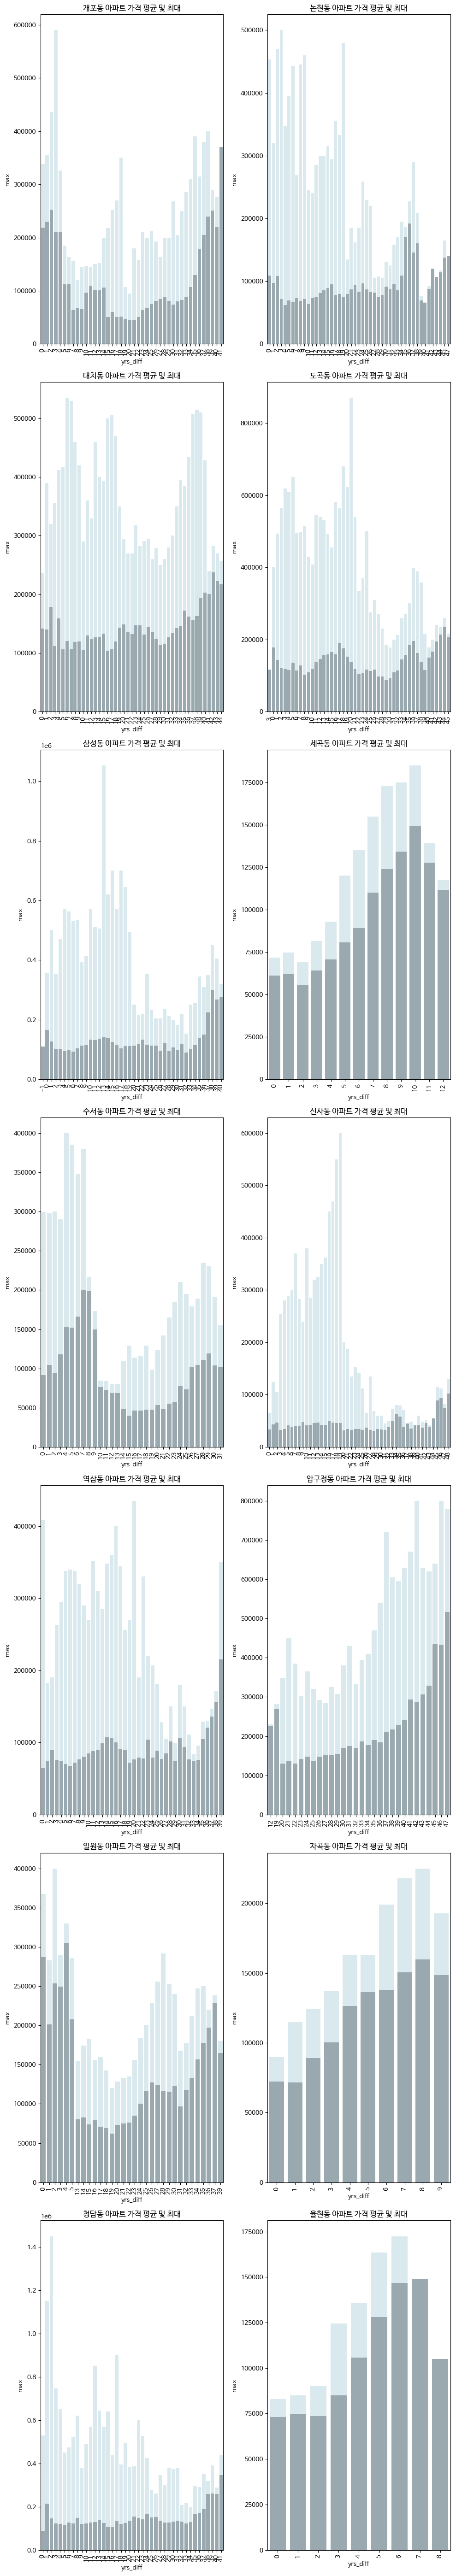

In [171]:
rows = 7
cols = 2

fig, axs = plt.subplots(nrows = rows, ncols = cols, figsize = (cols*5, rows*8))

for i, district in enumerate(dt_gangnam['동'].unique().tolist()):
    row = i // cols
    col = i % cols
    
    temp_df_dong = dist_per_dong(district)

    # Plot the barplots
    colors = ["black", "blue", "lightblue"]

    # sns.barplot(data=temp_df_dong, x='yrs_diff', y='min', alpha=0.5, color=colors[0], ax=axs[row, col])
    
    sns.barplot(data=temp_df_dong, x='yrs_diff', y='mean', alpha=0.5, color=colors[0], ax=axs[row, col])
    
    sns.barplot(data=temp_df_dong, x='yrs_diff', y='max', alpha=0.5, color=colors[2], ax=axs[row, col])
    
    # sns.lineplot(data=temp_df_dong, x='yrs_diff', y='mean', alpha=0.5, color=colors[1], ax=axs[row, col])
    
    axs[row, col].set_title(f"{district} 아파트 가격 평균 및 최대")
    axs[row, col].tick_params(axis='x', rotation=90)
    
plt.tight_layout()
plt.show()


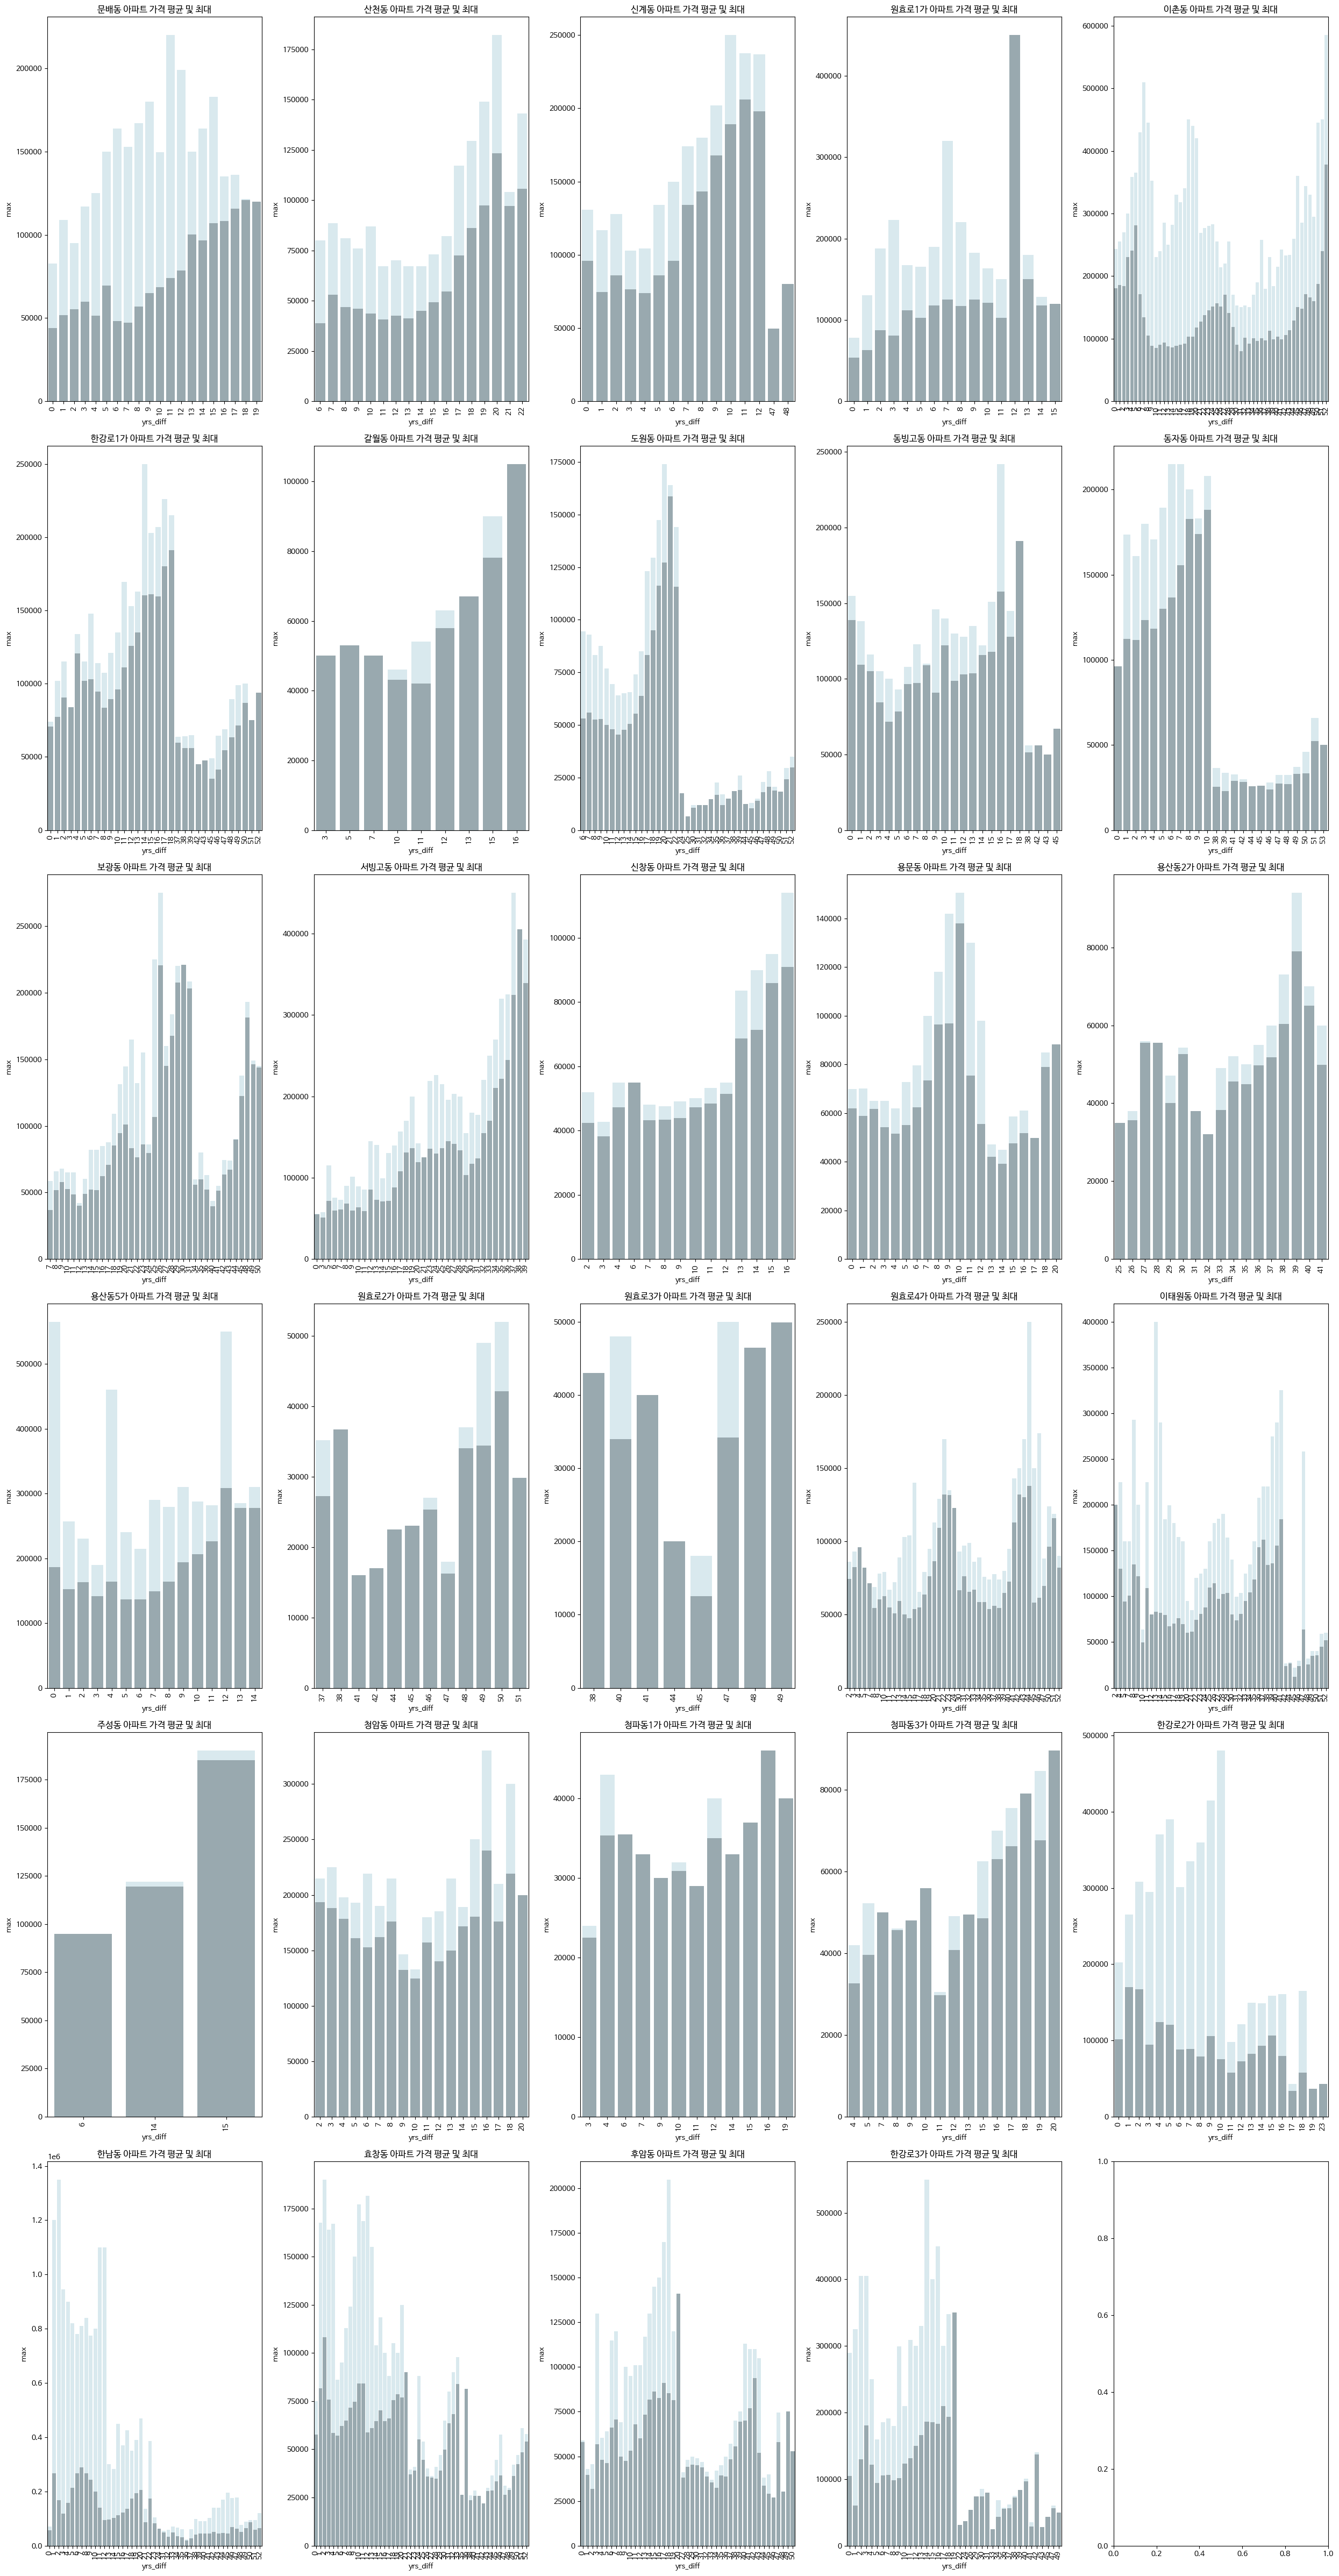

In [175]:
rows = 6
cols = 5

fig, axs = plt.subplots(nrows = rows, ncols = cols, figsize = (cols*5, rows*8))

for i, district in enumerate(dt_yongsan['동'].unique().tolist()):
    row = i // cols
    col = i % cols
    
    temp_df_dong = dist_per_dong(district)

    # Plot the barplots
    colors = ["black", "blue", "lightblue"]

    # sns.barplot(data=temp_df_dong, x='yrs_diff', y='min', alpha=0.5, color=colors[0], ax=axs[row, col])
    
    sns.barplot(data=temp_df_dong, x='yrs_diff', y='mean', alpha=0.5, color=colors[0], ax=axs[row, col])
    
    sns.barplot(data=temp_df_dong, x='yrs_diff', y='max', alpha=0.5, color=colors[2], ax=axs[row, col])
    
    # sns.lineplot(data=temp_df_dong, x='yrs_diff', y='mean', alpha=0.5, color=colors[1], ax=axs[row, col])
    
    axs[row, col].set_title(f"{district} 아파트 가격 평균 및 최대")
    axs[row, col].tick_params(axis='x', rotation=90)
    
plt.tight_layout()
plt.show()


In [179]:
len(dt_seongbuk['동'].unique())

30

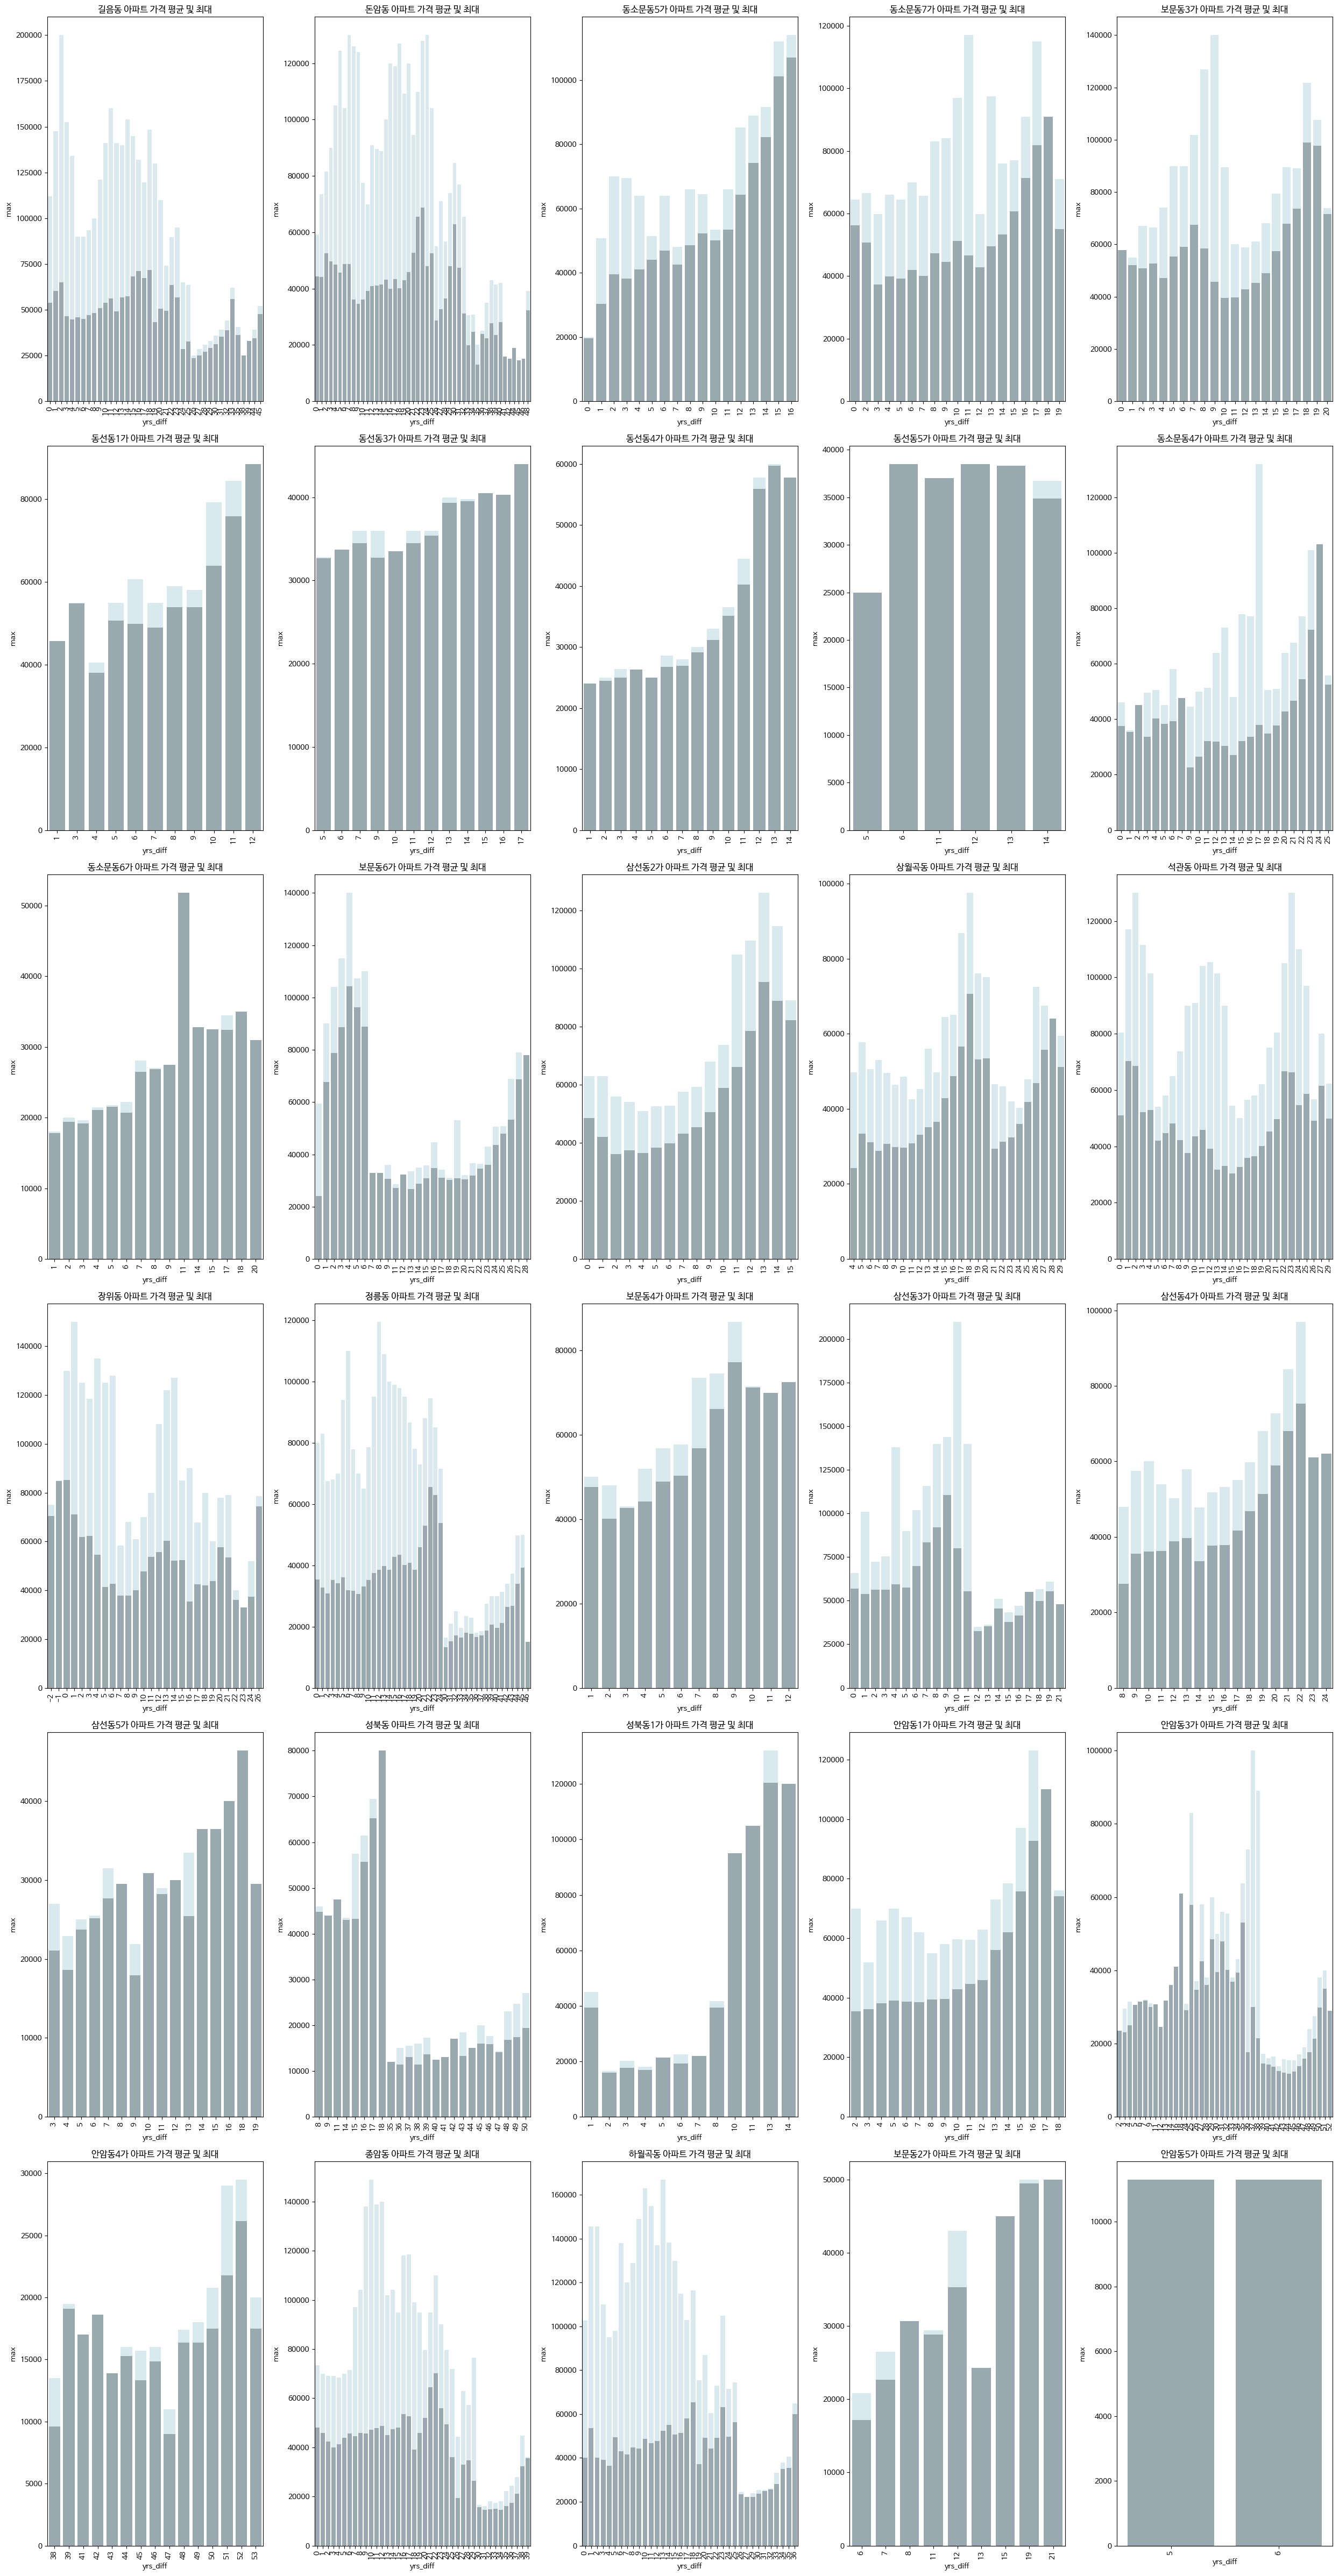

In [180]:
rows = 6
cols = 5

fig, axs = plt.subplots(nrows = rows, ncols = cols, figsize = (cols*5, rows*8))

for i, district in enumerate(dt_seongbuk['동'].unique().tolist()):
    row = i // cols
    col = i % cols
    
    temp_df_dong = dist_per_dong(district)

    # Plot the barplots
    colors = ["black", "blue", "lightblue"]

    # sns.barplot(data=temp_df_dong, x='yrs_diff', y='min', alpha=0.5, color=colors[0], ax=axs[row, col])
    
    sns.barplot(data=temp_df_dong, x='yrs_diff', y='mean', alpha=0.5, color=colors[0], ax=axs[row, col])
    
    sns.barplot(data=temp_df_dong, x='yrs_diff', y='max', alpha=0.5, color=colors[2], ax=axs[row, col])
    
    # sns.lineplot(data=temp_df_dong, x='yrs_diff', y='mean', alpha=0.5, color=colors[1], ax=axs[row, col])
    
    axs[row, col].set_title(f"{district} 아파트 가격 평균 및 최대")
    axs[row, col].tick_params(axis='x', rotation=90)
    
plt.tight_layout()
plt.show()


In [181]:
len(dt_seongdong['동'].unique())

17

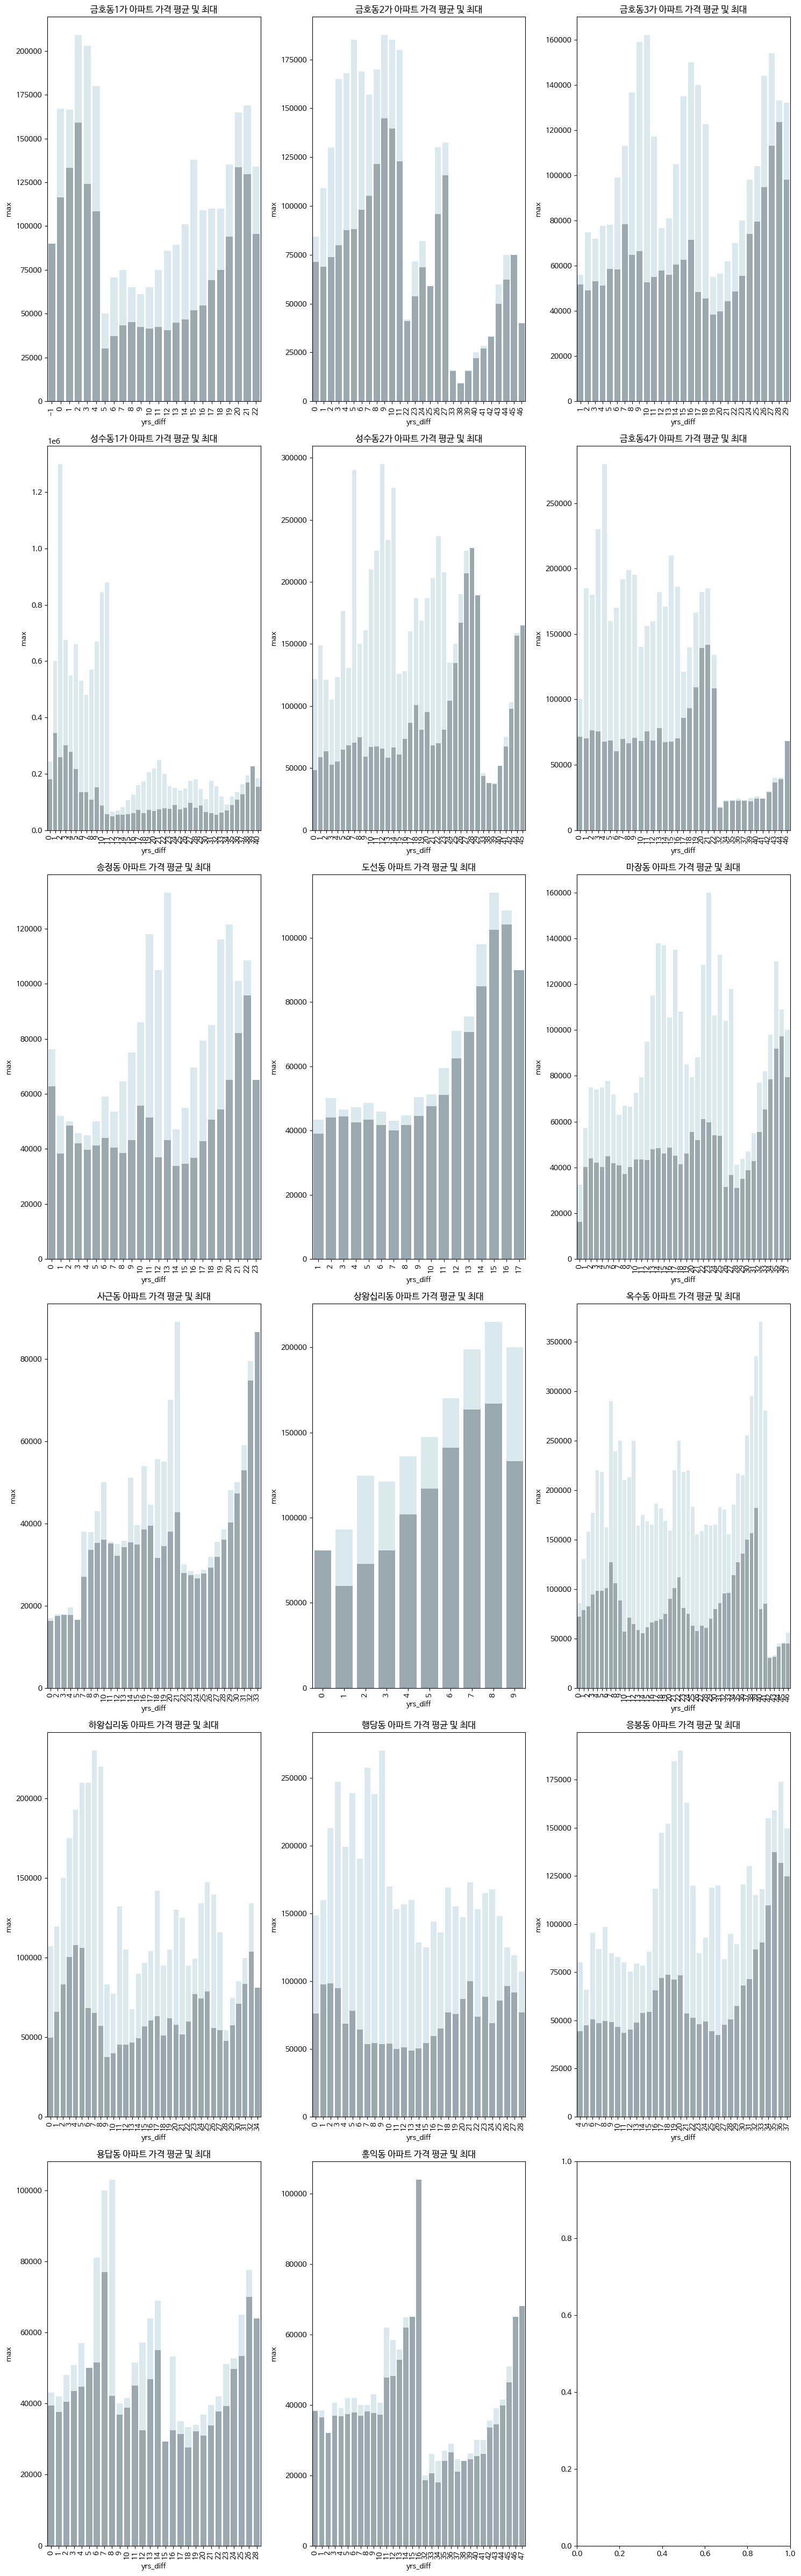

In [182]:
rows = 6
cols = 3

fig, axs = plt.subplots(nrows = rows, ncols = cols, figsize = (cols*5, rows*8))

for i, district in enumerate(dt_seongdong['동'].unique().tolist()):
    row = i // cols
    col = i % cols
    
    temp_df_dong = dist_per_dong(district)

    # Plot the barplots
    colors = ["black", "blue", "lightblue"]

    # sns.barplot(data=temp_df_dong, x='yrs_diff', y='min', alpha=0.5, color=colors[0], ax=axs[row, col])
    
    sns.barplot(data=temp_df_dong, x='yrs_diff', y='mean', alpha=0.5, color=colors[0], ax=axs[row, col])
    
    sns.barplot(data=temp_df_dong, x='yrs_diff', y='max', alpha=0.5, color=colors[2], ax=axs[row, col])
    
    # sns.lineplot(data=temp_df_dong, x='yrs_diff', y='mean', alpha=0.5, color=colors[1], ax=axs[row, col])
    
    axs[row, col].set_title(f"{district} 아파트 가격 평균 및 최대")
    axs[row, col].tick_params(axis='x', rotation=90)
    
plt.tight_layout()
plt.show()
